In [ ]:
#mount drive to save models
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.models import Sequential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

Epoch [1/100], Train Loss: 0.7318307757377625, Test Loss: 0.6351836323738098
Epoch [2/100], Train Loss: 0.6389611959457397, Test Loss: 0.5605036020278931
Epoch [3/100], Train Loss: 0.5685929656028748, Test Loss: 0.503753662109375
Epoch [4/100], Train Loss: 0.5119147896766663, Test Loss: 0.4562849700450897
Epoch [5/100], Train Loss: 0.46705806255340576, Test Loss: 0.41435110569000244
Epoch [6/100], Train Loss: 0.4268600642681122, Test Loss: 0.37646064162254333
Epoch [7/100], Train Loss: 0.3919294774532318, Test Loss: 0.3423941433429718
Epoch [8/100], Train Loss: 0.3595035970211029, Test Loss: 0.3136676847934723
Epoch [9/100], Train Loss: 0.3316929340362549, Test Loss: 0.28928181529045105
Epoch [10/100], Train Loss: 0.3090806305408478, Test Loss: 0.26840078830718994
Epoch [11/100], Train Loss: 0.2882783114910126, Test Loss: 0.250406414270401
Epoch [12/100], Train Loss: 0.2721221148967743, Test Loss: 0.2345772385597229
Epoch [13/100], Train Loss: 0.25559884309768677, Test Loss: 0.22158598

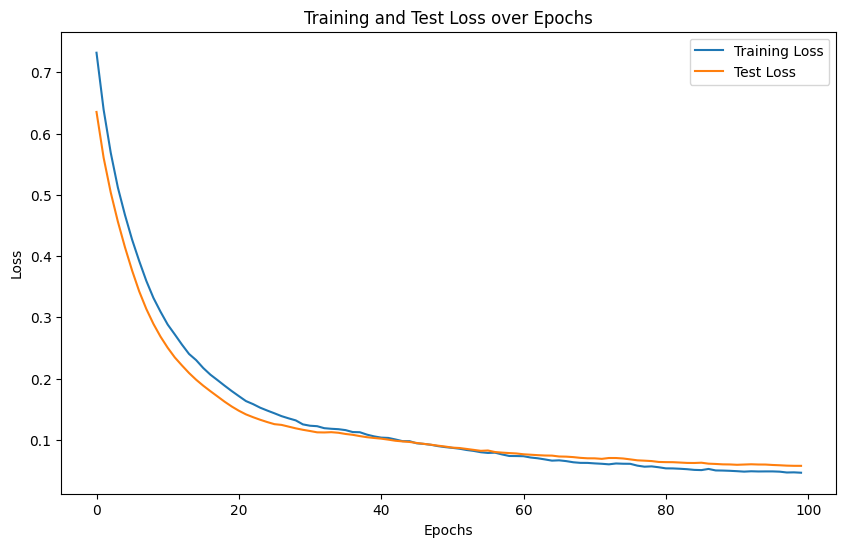

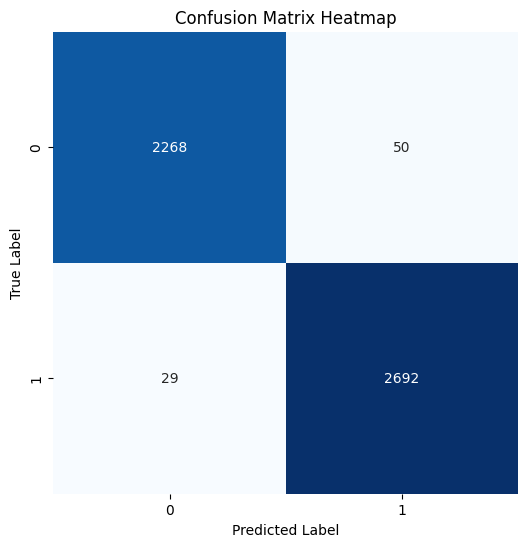

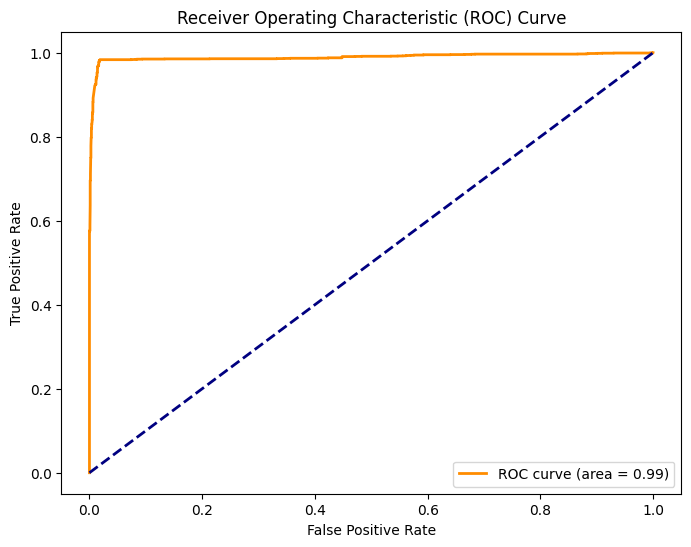


Performance Metrics:
Specificity: 0.9784
FAR: 0.02
Precision: 0.9818
Recall: 0.9893
F1 Score: 0.9855
Accuracy: 0.9843


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with added hidden layer and dropout
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = F.relu(self.hidden_layer1(x))
        x = F.relu(self.hidden_layer2(x))
        x = self.dropout(x)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add L2 regularization

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience)
t = time.time() - s
print("training time:", t)

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.4f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))

In [ ]:
torch.save(snn_model.state_dict(), "/content/drive/My Drive/Final year project/models/final_model_snn.keras")

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with added hidden layer and dropout
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = F.relu(self.hidden_layer1(x))
        x = F.relu(self.hidden_layer2(x))
        x = self.dropout(x)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, num_epochs, learning_rate, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add L2 regularization

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Cross-validation with FAR calculation
def cross_validate_snn(X, y, num_folds, input_size, hidden_size1, hidden_size2, output_size, dropout_rate, num_epochs, learning_rate, patience):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    roc_auc_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    accuracy_scores = []
    far_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Convert data to PyTorch tensors
        train_data = torch.tensor(X_train.values, dtype=torch.float32)
        labels = torch.tensor(y_train.values, dtype=torch.long)
        test_data = torch.tensor(X_test.values, dtype=torch.float32)
        test_labels = torch.tensor(y_test.values, dtype=torch.long)

        snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
        history = train_snn(snn_model, train_data, labels, num_epochs, learning_rate, patience)

        with torch.no_grad():
            test_outputs = snn_model(test_data)
            _, predicted = torch.max(test_outputs, 1)

        # Calculate performance metrics
        fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
        roc_auc = auc(fpr, tpr)
        roc_auc_scores.append(roc_auc)

        precision = precision_score(test_labels, predicted)
        recall = recall_score(test_labels, predicted)
        f1 = f1_score(test_labels, predicted)
        accuracy = accuracy_score(test_labels, predicted)

        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        accuracy_scores.append(accuracy)

        # Calculate False Alarm Rate (FAR)
        TN, FP, FN, TP = confusion_matrix(test_labels, predicted).ravel()
        far = FP / (FP + TN)
        far_scores.append(far)

    # Calculate mean and standard deviation of performance metrics
    roc_auc_mean = np.mean(roc_auc_scores)
    roc_auc_std = np.std(roc_auc_scores)
    precision_mean = np.mean(precision_scores)
    recall_mean = np.mean(recall_scores)
    f1_mean = np.mean(f1_scores)
    accuracy_mean = np.mean(accuracy_scores)
    far_mean = np.mean(far_scores)
    far_std = np.std(far_scores)

    print("\nPerformance Metrics:")
    print(f"ROC AUC: {roc_auc_mean:.4f} ± {roc_auc_std:.4f}")
    print(f"Precision: {precision_mean:.4f}")
    print(f"Recall: {recall_mean:.4f}")
    print(f"F1 Score: {f1_mean:.4f}")
    print(f"Accuracy: {accuracy_mean:.4f}")
    print(f"False Alarm Rate (FAR): {far_mean:.4f} ± {far_std:.4f}")

# Initialize SNN model and cross-validate
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10
num_folds = 5

cross_validate_snn(X, y, num_folds, input_size, hidden_size1, hidden_size2, output_size, dropout_rate, num_epochs, learning_rate, patience)

Epoch [1/100], Train Loss: 0.7520098090171814, Test Loss: 0.6582658886909485
Epoch [2/100], Train Loss: 0.6719823479652405, Test Loss: 0.5941689014434814
Epoch [3/100], Train Loss: 0.6078024506568909, Test Loss: 0.5433616638183594
Epoch [4/100], Train Loss: 0.5578403472900391, Test Loss: 0.5000085830688477
Epoch [5/100], Train Loss: 0.5168921947479248, Test Loss: 0.4600018858909607
Epoch [6/100], Train Loss: 0.4769808351993561, Test Loss: 0.42323195934295654
Epoch [7/100], Train Loss: 0.4419533908367157, Test Loss: 0.38957563042640686
Epoch [8/100], Train Loss: 0.40875253081321716, Test Loss: 0.35831359028816223
Epoch [9/100], Train Loss: 0.37963181734085083, Test Loss: 0.3298010230064392
Epoch [10/100], Train Loss: 0.35299256443977356, Test Loss: 0.3039620518684387
Epoch [11/100], Train Loss: 0.3291572034358978, Test Loss: 0.28078967332839966
Epoch [12/100], Train Loss: 0.30547448992729187, Test Loss: 0.2602701783180237
Epoch [13/100], Train Loss: 0.28672829270362854, Test Loss: 0.242

Epoch [1/100], Train Loss: 0.7196279764175415, Test Loss: 0.7088943719863892
Epoch [2/100], Train Loss: 0.7171298265457153, Test Loss: 0.7068429589271545
Epoch [3/100], Train Loss: 0.7101902365684509, Test Loss: 0.7049969434738159
Epoch [4/100], Train Loss: 0.7119435667991638, Test Loss: 0.7033306360244751
Epoch [5/100], Train Loss: 0.7051223516464233, Test Loss: 0.7017198204994202
Epoch [6/100], Train Loss: 0.7030742764472961, Test Loss: 0.7000235319137573
Epoch [7/100], Train Loss: 0.7021576762199402, Test Loss: 0.6982511281967163
Epoch [8/100], Train Loss: 0.7022024393081665, Test Loss: 0.6966692805290222
Epoch [9/100], Train Loss: 0.6990372538566589, Test Loss: 0.6952601671218872
Epoch [10/100], Train Loss: 0.697918176651001, Test Loss: 0.6940227746963501
Epoch [11/100], Train Loss: 0.6943322420120239, Test Loss: 0.6929414868354797
Epoch [12/100], Train Loss: 0.6965150833129883, Test Loss: 0.692068874835968
Epoch [13/100], Train Loss: 0.6955541372299194, Test Loss: 0.69138354063034

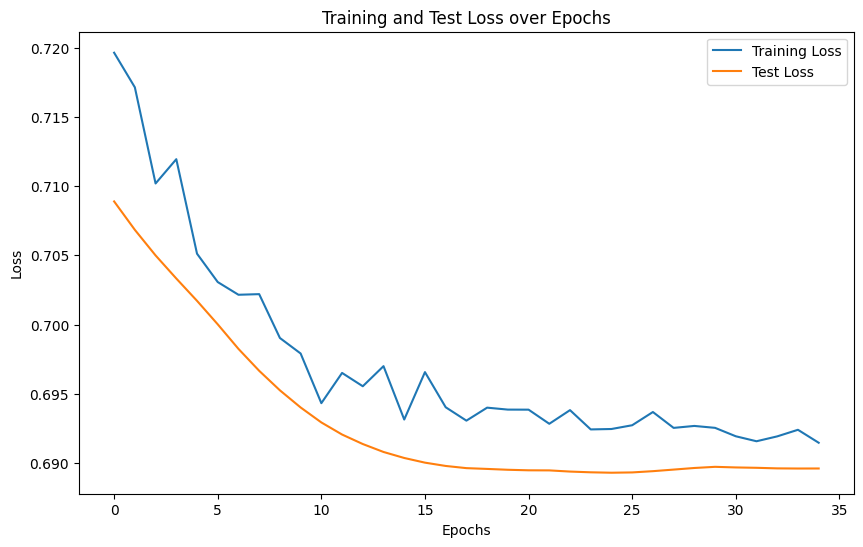

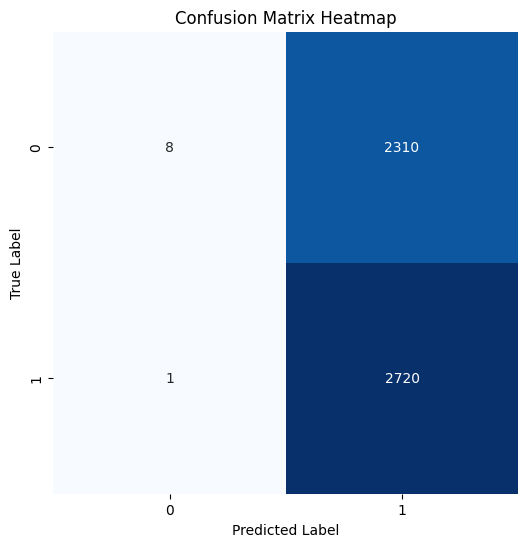

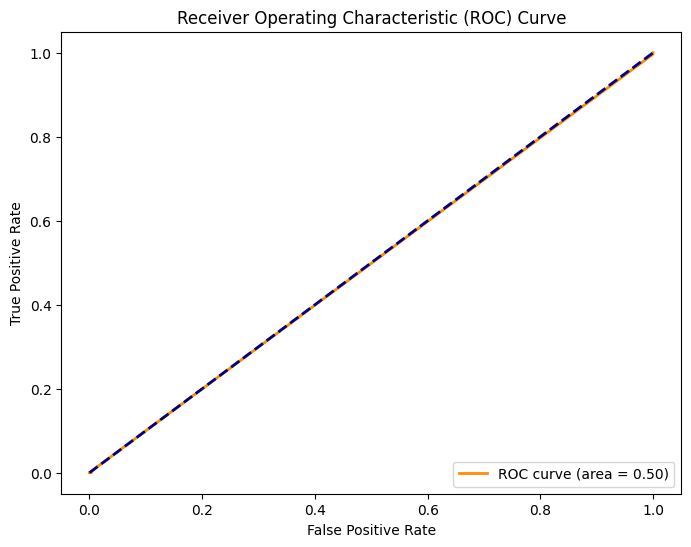


Performance Metrics:
Specificity: 0.0035
FAR: 1.00
Precision: 0.5408
Recall: 0.9996
F1 Score: 0.7018
Accuracy: 0.5414


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with batch normalization
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)  # Add batch normalization
        self.spike = nn.Hardtanh(0, 1)
        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)  # Add batch normalization
        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.bn1(x)  # Apply batch normalization
        x = self.spike(x - self.threshold)
        x = F.relu(self.hidden_layer1(x))
        x = self.bn2(x)  # Apply batch normalization
        x = F.relu(self.hidden_layer2(x))
        x = self.dropout(x)
        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with early stopping (same as before)
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add L2 regularization

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history
# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience)
t = time.time() - s
print("training time:", t)

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.4f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))

Epoch [1/100], Train Loss: 1.6626136302947998, Test Loss: 0.6771925091743469
Epoch [2/100], Train Loss: 0.9208229184150696, Test Loss: 0.6526867747306824
Epoch [3/100], Train Loss: 0.6466052532196045, Test Loss: 0.6256168484687805
Epoch [4/100], Train Loss: 0.5107061862945557, Test Loss: 0.5949267148971558
Epoch [5/100], Train Loss: 0.45951634645462036, Test Loss: 0.5628134608268738
Epoch [6/100], Train Loss: 0.4033110439777374, Test Loss: 0.5283838510513306
Epoch [7/100], Train Loss: 0.3655294179916382, Test Loss: 0.49134838581085205
Epoch [8/100], Train Loss: 0.3535102605819702, Test Loss: 0.45188549160957336
Epoch [9/100], Train Loss: 0.3377210199832916, Test Loss: 0.4098660349845886
Epoch [10/100], Train Loss: 0.3137848377227783, Test Loss: 0.3666936457157135
Epoch [11/100], Train Loss: 0.30148789286613464, Test Loss: 0.324643611907959
Epoch [12/100], Train Loss: 0.2891821265220642, Test Loss: 0.28558292984962463
Epoch [13/100], Train Loss: 0.26852673292160034, Test Loss: 0.2512978

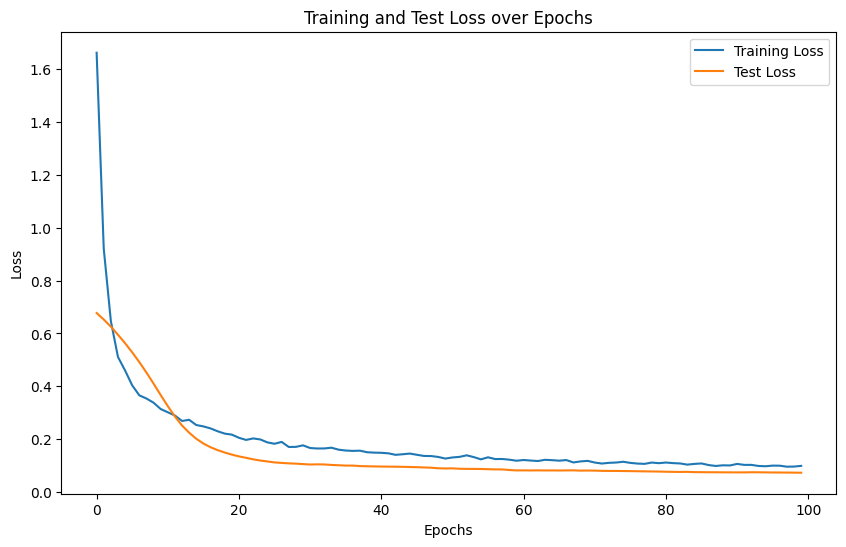

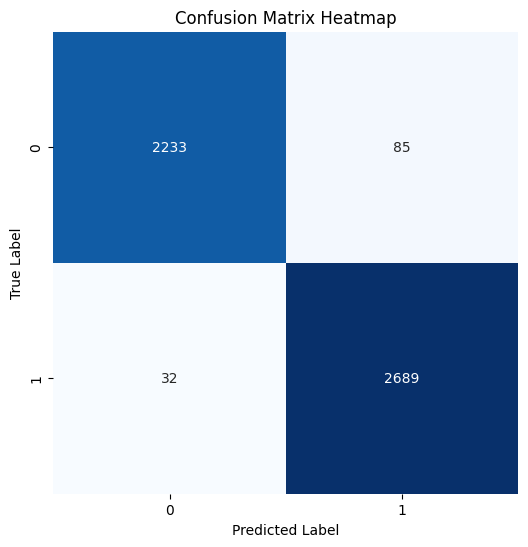

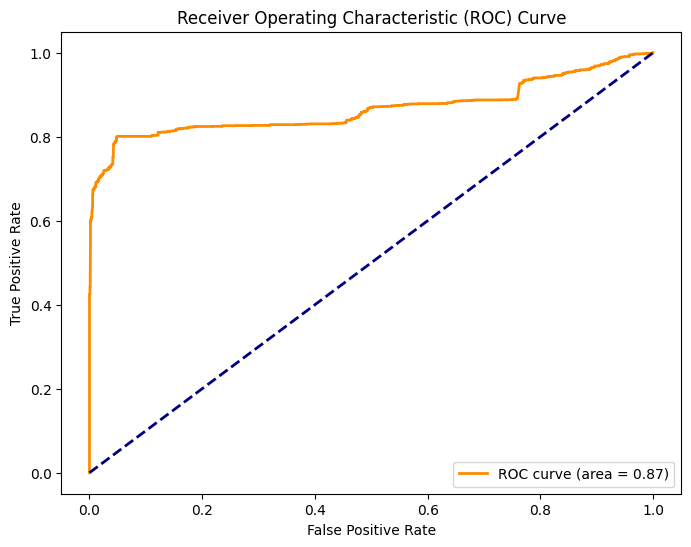


Performance Metrics:
Specificity: 0.9633
FAR: 0.04
Precision: 0.9694
Recall: 0.9882
F1 Score: 0.9787
Accuracy: 0.9768


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with added hidden layer and dropout

import torch.nn as nn
import torch.nn.functional as F

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size2, num_heads=4, batch_first=True)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size2)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = F.relu(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = F.relu(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x = torch.mm(x, self.synaptic_weights)
        return x


def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience)
t = time.time() - s
print("training time:", t)

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.4f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))

Epoch [1/100], Train Loss: 1.9496771097183228, Test Loss: 0.6741484999656677
Epoch [2/100], Train Loss: 1.0461782217025757, Test Loss: 0.6347159147262573
Epoch [3/100], Train Loss: 0.721723735332489, Test Loss: 0.596168041229248
Epoch [4/100], Train Loss: 0.5895941257476807, Test Loss: 0.557892918586731
Epoch [5/100], Train Loss: 0.5252408981323242, Test Loss: 0.5205486416816711
Epoch [6/100], Train Loss: 0.47639867663383484, Test Loss: 0.4841702878475189
Epoch [7/100], Train Loss: 0.4368460178375244, Test Loss: 0.4482114613056183
Epoch [8/100], Train Loss: 0.4221717119216919, Test Loss: 0.4134733974933624
Epoch [9/100], Train Loss: 0.3985685706138611, Test Loss: 0.3799627125263214
Epoch [10/100], Train Loss: 0.3842785954475403, Test Loss: 0.34828418493270874
Epoch [11/100], Train Loss: 0.35723796486854553, Test Loss: 0.31913015246391296
Epoch [12/100], Train Loss: 0.3591920733451843, Test Loss: 0.29228442907333374
Epoch [13/100], Train Loss: 0.3413960039615631, Test Loss: 0.2680122256

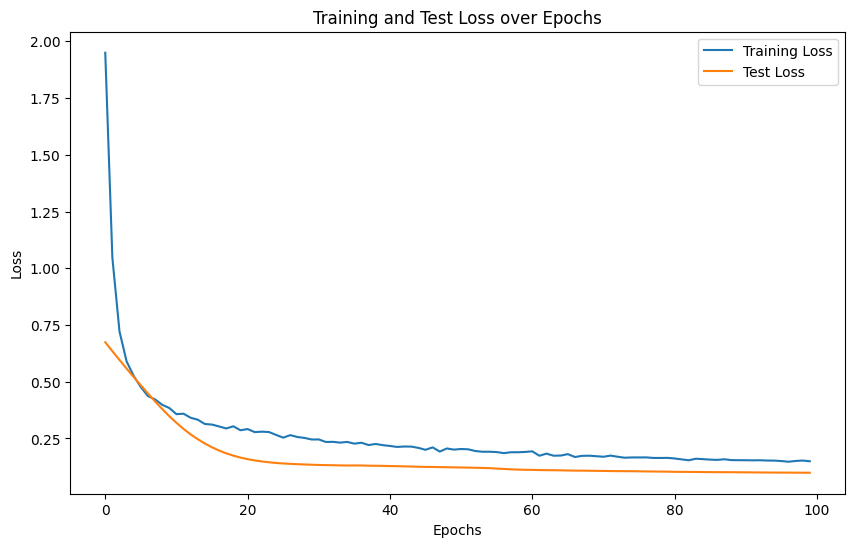

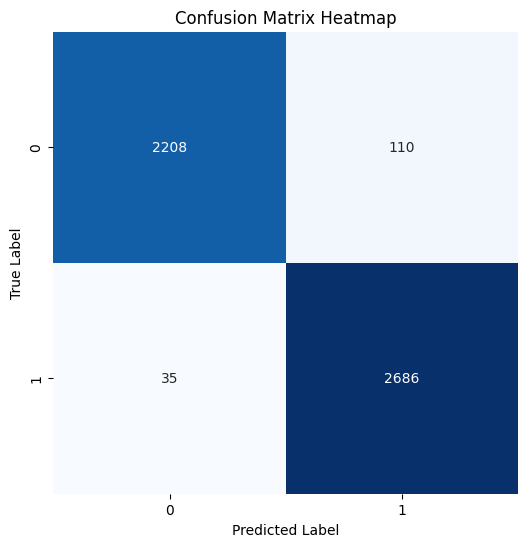

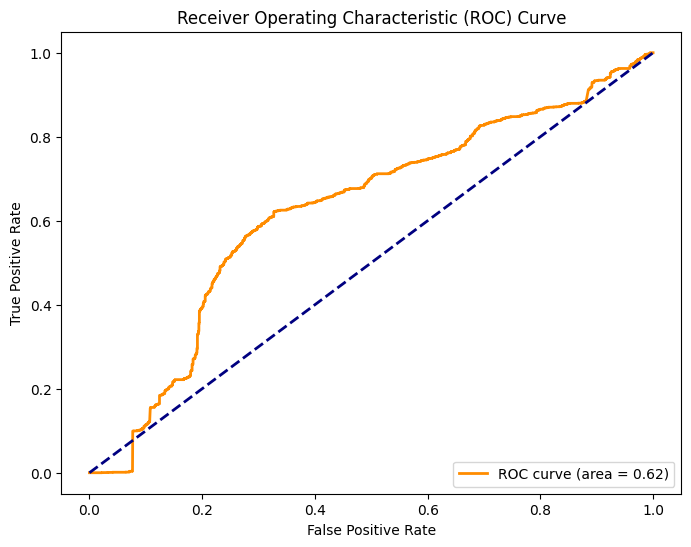


Performance Metrics:
Specificity: 0.9525
FAR: 0.05
Precision: 0.9607
Recall: 0.9871
F1 Score: 0.9737
Accuracy: 0.9712


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Load data
file_path1 = '/content/drive/MyDrive/Final year project/datafinal/processed_train.csv'
data = pd.read_csv(file_path1)

# Split into train and test sets
X = data.drop(labels='class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=4)

# Convert data to PyTorch tensors
train_data = torch.tensor(X_train.values, dtype=torch.float32)
labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# Define SNN model with added hidden layer and dropout

import torch.nn as nn
import torch.nn.functional as F

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.Hardtanh(0, 1)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size2, num_heads=4, batch_first=True)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size2)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size2, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = F.relu(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = F.relu(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adamax(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # Add L2 regularization

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 128
hidden_size2 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, output_size, dropout_rate)
import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience)
t = time.time() - s
print("training time:", t)

# Plot the training and test loss
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# SNN on the test set
with torch.no_grad():
    test_outputs = snn_model(test_data)
    _, predicted = torch.max(test_outputs, 1)

# Calculate confusion matrix
conf_mat = confusion_matrix(test_labels, predicted)

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate specificity and FAR from confusion matrix
TN = conf_mat[0, 0]
FP = conf_mat[0, 1]
FN = conf_mat[1, 0]
TP = conf_mat[1, 1]

specificity = TN / (TN + FP)
far = FP / (FP + TN)

# Calculate additional performance metrics
precision = precision_score(test_labels, predicted)
recall = recall_score(test_labels, predicted)
f1 = f1_score(test_labels, predicted)
accuracy = accuracy_score(test_labels, predicted)

# ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print performance metrics
print("\nPerformance Metrics:")
print("Specificity: {:.4f}".format(specificity))
print("FAR: {:.2f}".format(far))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("Accuracy: {:.4f}".format(accuracy))

Training with Adam optimizer:
Epoch [1/100], Train Loss: 1.35448157787323, Test Loss: 0.6879715919494629
Epoch [2/100], Train Loss: 0.7250337600708008, Test Loss: 0.6659350991249084
Epoch [3/100], Train Loss: 0.532010018825531, Test Loss: 0.6476597189903259
Epoch [4/100], Train Loss: 0.5055574178695679, Test Loss: 0.6325778365135193
Epoch [5/100], Train Loss: 0.4625858664512634, Test Loss: 0.6194458603858948
Epoch [6/100], Train Loss: 0.43608078360557556, Test Loss: 0.6063688397407532
Epoch [7/100], Train Loss: 0.41977089643478394, Test Loss: 0.5931837558746338
Epoch [8/100], Train Loss: 0.38756081461906433, Test Loss: 0.5785203576087952
Epoch [9/100], Train Loss: 0.38320261240005493, Test Loss: 0.561677098274231
Epoch [10/100], Train Loss: 0.3797769844532013, Test Loss: 0.5427919030189514
Epoch [11/100], Train Loss: 0.34432217478752136, Test Loss: 0.5221500992774963
Epoch [12/100], Train Loss: 0.3438056707382202, Test Loss: 0.49872925877571106
Epoch [13/100], Train Loss: 0.32251888513

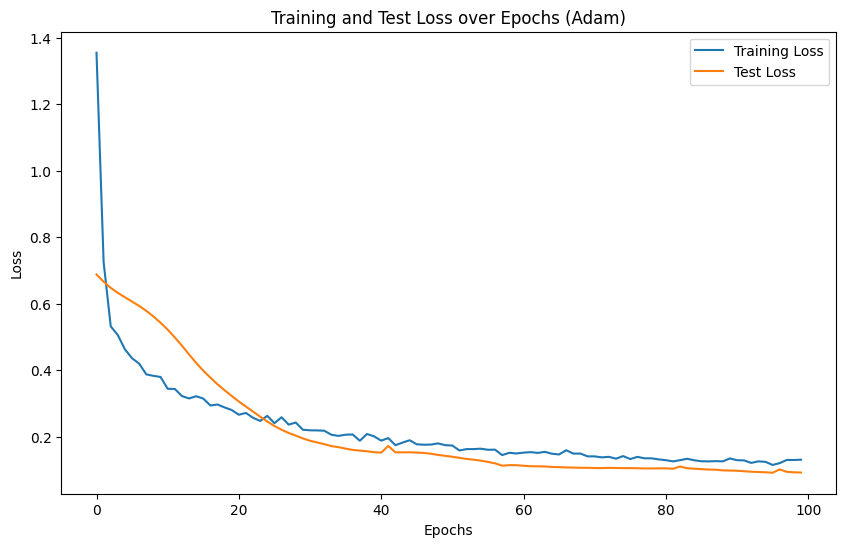


Performance Metrics:
Specificity: 0.9525
FAR: 0.05
Precision: 0.9562
Recall: 0.9868
F1 Score: 0.9712
Accuracy: 0.9684
Training with SGD optimizer:
Epoch [1/100], Train Loss: 0.12558303773403168, Test Loss: 0.09177391976118088
Epoch [2/100], Train Loss: 0.12203758955001831, Test Loss: 0.09150828421115875
Epoch [3/100], Train Loss: 0.12746499478816986, Test Loss: 0.09118561446666718
Epoch [4/100], Train Loss: 0.13004563748836517, Test Loss: 0.09079340100288391
Epoch [5/100], Train Loss: 0.12178777158260345, Test Loss: 0.09096129983663559
Epoch [6/100], Train Loss: 0.12074840813875198, Test Loss: 0.09180919826030731
Epoch [7/100], Train Loss: 0.12827016413211823, Test Loss: 0.0909556970000267
Epoch [8/100], Train Loss: 0.11810555309057236, Test Loss: 0.0904732272028923
Epoch [9/100], Train Loss: 0.12068147212266922, Test Loss: 0.09032394737005234
Epoch [10/100], Train Loss: 0.12362145632505417, Test Loss: 0.09009521454572678
Epoch [11/100], Train Loss: 0.12645035982131958, Test Loss: 0.0

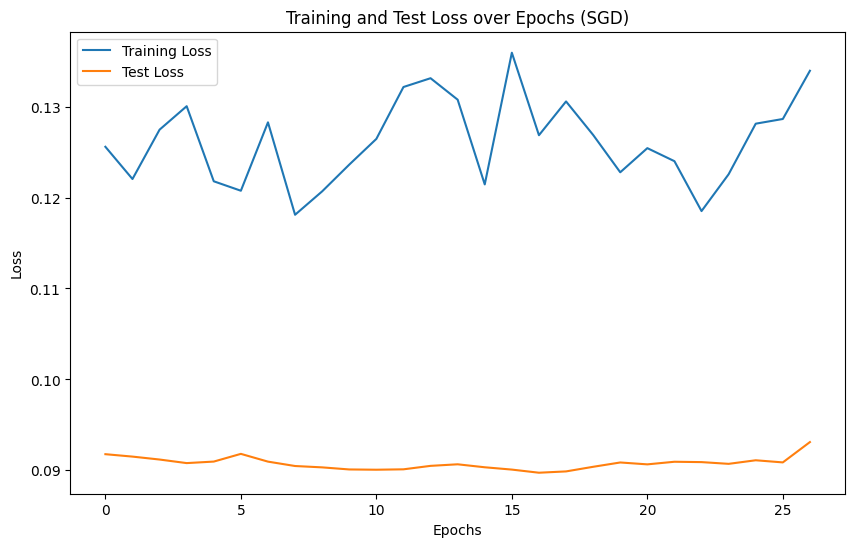


Performance Metrics:
Specificity: 0.9525
FAR: 0.05
Precision: 0.9554
Recall: 0.9831
F1 Score: 0.9690
Accuracy: 0.9661
Training with RMSprop optimizer:
Epoch [1/100], Train Loss: 0.12915143370628357, Test Loss: 8.526399612426758
Epoch [2/100], Train Loss: 0.4241175055503845, Test Loss: 0.39362871646881104
Epoch [3/100], Train Loss: 0.4116588234901428, Test Loss: 0.5979072451591492
Epoch [4/100], Train Loss: 0.26699140667915344, Test Loss: 0.5546031594276428
Epoch [5/100], Train Loss: 0.19970741868019104, Test Loss: 0.16520512104034424
Epoch [6/100], Train Loss: 0.18200081586837769, Test Loss: 0.13726870715618134
Epoch [7/100], Train Loss: 0.17264088988304138, Test Loss: 0.14341427385807037
Epoch [8/100], Train Loss: 0.16988742351531982, Test Loss: 0.13094618916511536
Epoch [9/100], Train Loss: 0.15517164766788483, Test Loss: 0.13177084922790527
Epoch [10/100], Train Loss: 0.15649786591529846, Test Loss: 0.14558738470077515
Epoch [11/100], Train Loss: 0.15007780492305756, Test Loss: 0.1

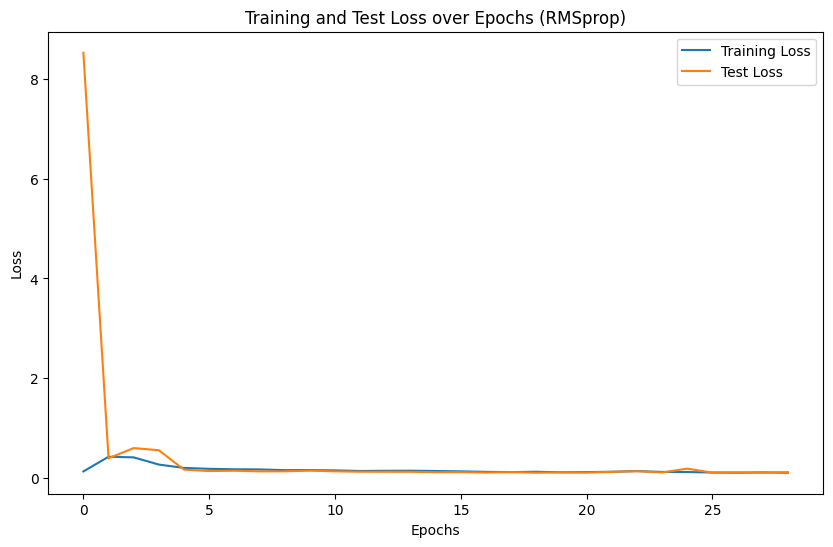


Performance Metrics:
Specificity: 0.9525
FAR: 0.05
Precision: 0.9512
Recall: 0.9890
F1 Score: 0.9697
Accuracy: 0.9667
Training with Adagrad optimizer:
Epoch [1/100], Train Loss: 0.10039308667182922, Test Loss: 0.10426519811153412
Epoch [2/100], Train Loss: 0.09920761734247208, Test Loss: 0.10281866788864136
Epoch [3/100], Train Loss: 0.09408765286207199, Test Loss: 0.1007092073559761
Epoch [4/100], Train Loss: 0.09868329763412476, Test Loss: 0.10251499712467194
Epoch [5/100], Train Loss: 0.09986872971057892, Test Loss: 0.09884334355592728
Epoch [6/100], Train Loss: 0.09139082580804825, Test Loss: 0.09771813452243805
Epoch [7/100], Train Loss: 0.09236136078834534, Test Loss: 0.09754686057567596
Epoch [8/100], Train Loss: 0.09497278928756714, Test Loss: 0.09562180191278458
Epoch [9/100], Train Loss: 0.0959600880742073, Test Loss: 0.09626460075378418
Epoch [10/100], Train Loss: 0.09114950150251389, Test Loss: 0.09509032219648361
Epoch [11/100], Train Loss: 0.09640436619520187, Test Loss:

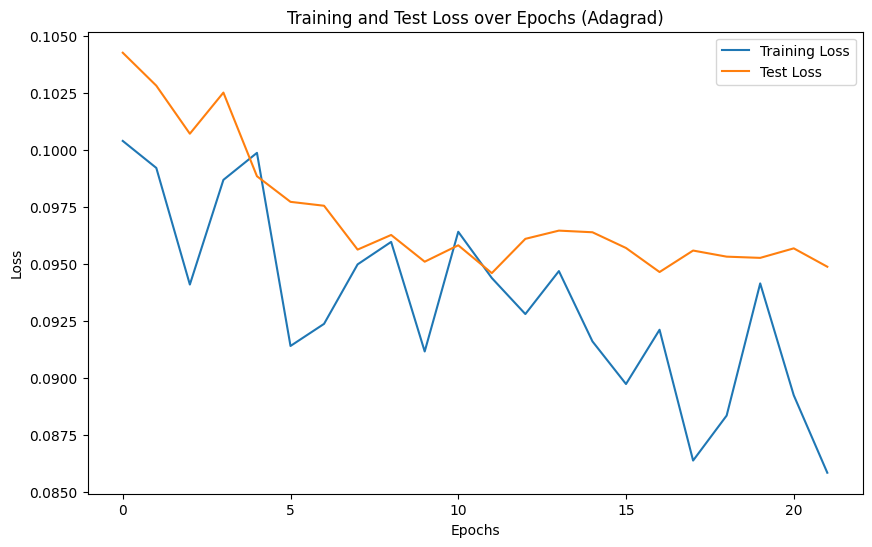


Performance Metrics:
Specificity: 0.9525
FAR: 0.05
Precision: 0.9563
Recall: 0.9890
F1 Score: 0.9724
Accuracy: 0.9696


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)

# Test different optimizers
for optimizer_class in [optim.Adam, optim.SGD, optim.RMSprop, optim.Adagrad]:
    print(f"Training with {optimizer_class.__name__} optimizer:")
    import time
    s = time.time()
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience)
    t = time.time() - s
    print("training time:", t)

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs ({optimizer_class.__name__})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate performance metrics
    conf_mat = confusion_matrix(test_labels, predicted)
    specificity = TN / (TN + FP)
    far = FP / (FP + TN)
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.4f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("Accuracy: {:.4f}".format(accuracy))


far 0.03 ADAGRAD BEST


Training with Adam optimizer:
Epoch [1/100], Train Loss: 1.426386833190918, Test Loss: 0.6550464034080505
Epoch [2/100], Train Loss: 0.7855679392814636, Test Loss: 0.6454896926879883
Epoch [3/100], Train Loss: 0.5477249622344971, Test Loss: 0.6335176229476929
Epoch [4/100], Train Loss: 0.5057364106178284, Test Loss: 0.6191022992134094
Epoch [5/100], Train Loss: 0.43621107935905457, Test Loss: 0.6038898229598999
Epoch [6/100], Train Loss: 0.410561203956604, Test Loss: 0.6032142639160156
Epoch [7/100], Train Loss: 0.38252535462379456, Test Loss: 0.571711540222168
Epoch [8/100], Train Loss: 0.36613544821739197, Test Loss: 0.5555248260498047
Epoch [9/100], Train Loss: 0.3729586601257324, Test Loss: 0.5386985540390015
Epoch [10/100], Train Loss: 0.3359193801879883, Test Loss: 0.5270161032676697
Epoch [11/100], Train Loss: 0.3385765254497528, Test Loss: 0.5052886605262756
Epoch [12/100], Train Loss: 0.3401781916618347, Test Loss: 0.4853724539279938
Epoch [13/100], Train Loss: 0.3237446844577

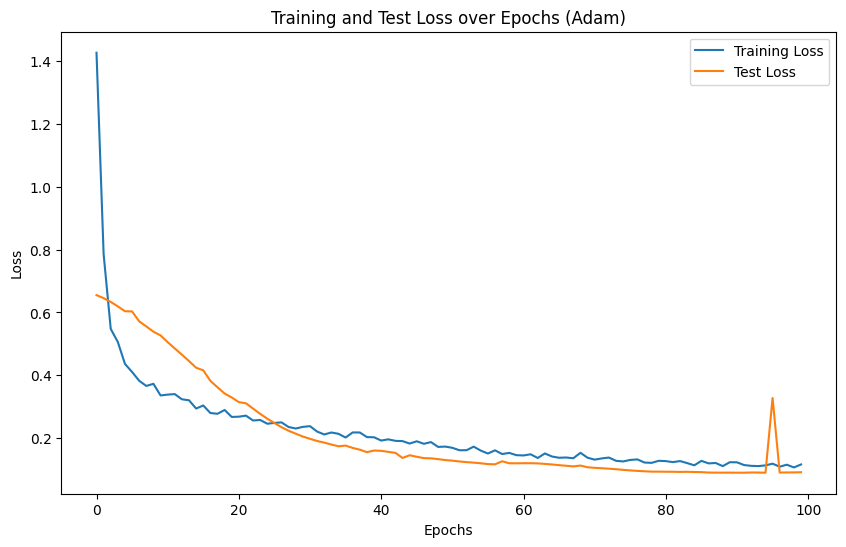

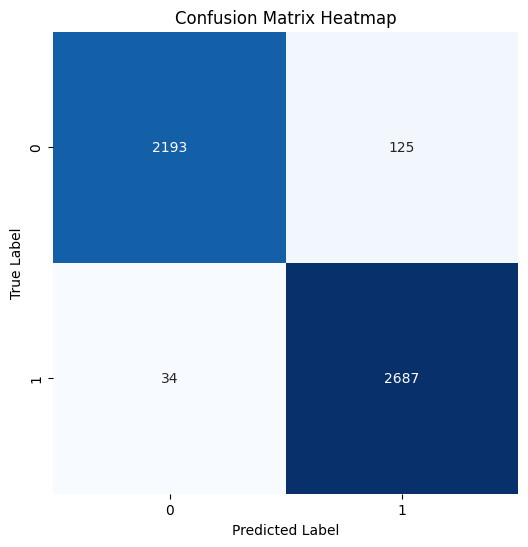

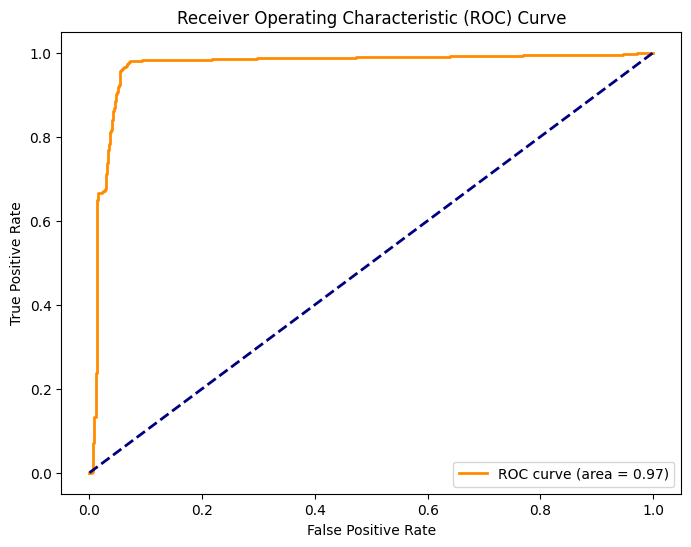


Performance Metrics:
Specificity: 0.9461
FAR: 0.05
Precision: 0.9555
Recall: 0.9875
F1 Score: 0.9713
Accuracy: 0.9684
Training with SGD optimizer:
Epoch [1/100], Train Loss: 0.11112959682941437, Test Loss: 0.09031275659799576
Epoch [2/100], Train Loss: 0.11977560818195343, Test Loss: 0.08994366973638535
Epoch [3/100], Train Loss: 0.11443816870450974, Test Loss: 0.0908045694231987
Epoch [4/100], Train Loss: 0.11156069487333298, Test Loss: 0.09056532382965088
Epoch [5/100], Train Loss: 0.11611602455377579, Test Loss: 0.09105605632066727
Epoch [6/100], Train Loss: 0.11393090337514877, Test Loss: 0.09007151424884796
Epoch [7/100], Train Loss: 0.11518407613039017, Test Loss: 0.08928817510604858
Epoch [8/100], Train Loss: 0.11948343366384506, Test Loss: 0.0890810564160347
Epoch [9/100], Train Loss: 0.11472082138061523, Test Loss: 0.08897720277309418
Epoch [10/100], Train Loss: 0.12093742936849594, Test Loss: 0.08860801160335541
Epoch [11/100], Train Loss: 0.10785555839538574, Test Loss: 0.0

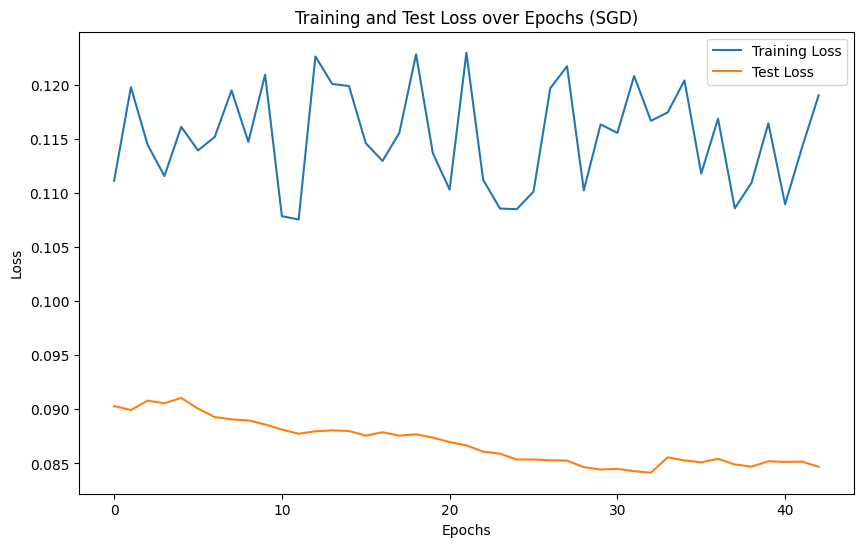

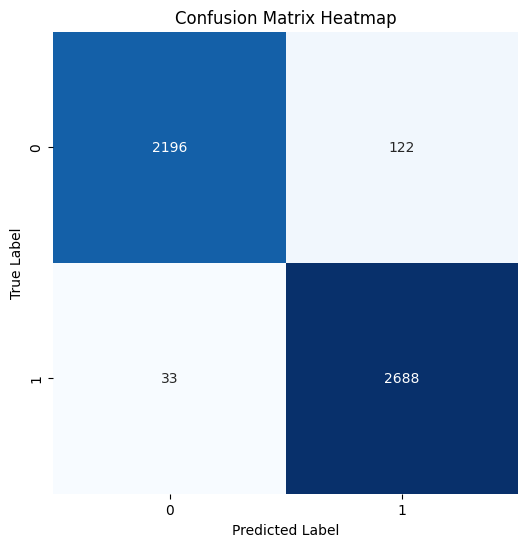

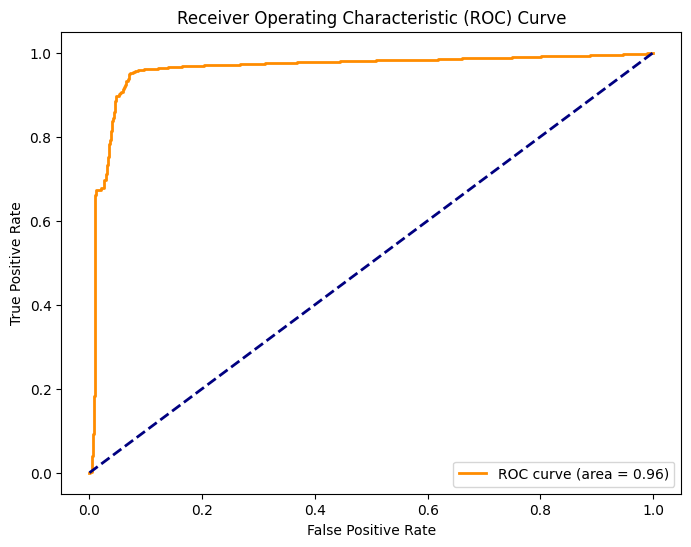


Performance Metrics:
Specificity: 0.9474
FAR: 0.05
Precision: 0.9566
Recall: 0.9879
F1 Score: 0.9720
Accuracy: 0.9692
Training with RMSprop optimizer:
Epoch [1/100], Train Loss: 0.11174251139163971, Test Loss: 18.46847152709961
Epoch [2/100], Train Loss: 0.7572358846664429, Test Loss: 0.5311521887779236
Epoch [3/100], Train Loss: 0.35195356607437134, Test Loss: 0.23006516695022583
Epoch [4/100], Train Loss: 0.208637997508049, Test Loss: 0.19989898800849915
Epoch [5/100], Train Loss: 0.17646852135658264, Test Loss: 0.1268579214811325
Epoch [6/100], Train Loss: 0.15404072403907776, Test Loss: 0.13698267936706543
Epoch [7/100], Train Loss: 0.1287943422794342, Test Loss: 0.1470605880022049
Epoch [8/100], Train Loss: 0.13824892044067383, Test Loss: 0.12200751900672913
Epoch [9/100], Train Loss: 0.1318187415599823, Test Loss: 0.1295902281999588
Epoch [10/100], Train Loss: 0.12579035758972168, Test Loss: 0.11533040553331375
Epoch [11/100], Train Loss: 0.12224801629781723, Test Loss: 0.115130

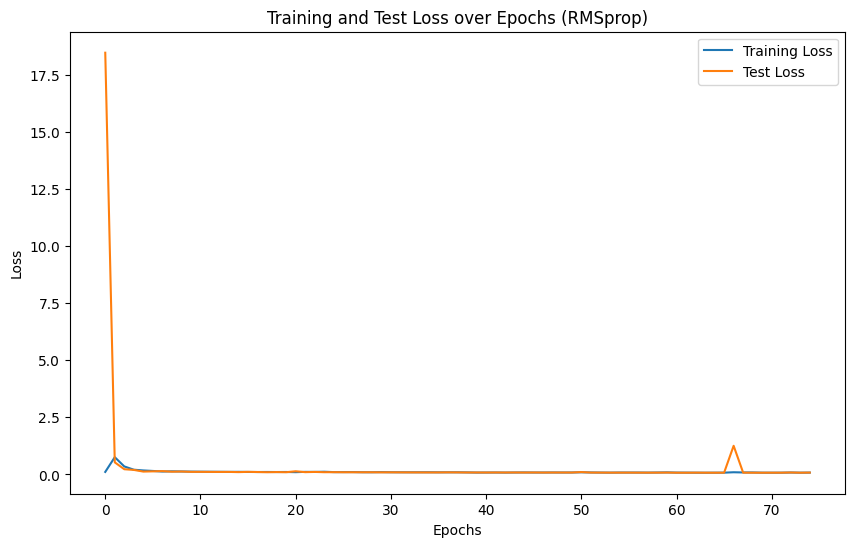

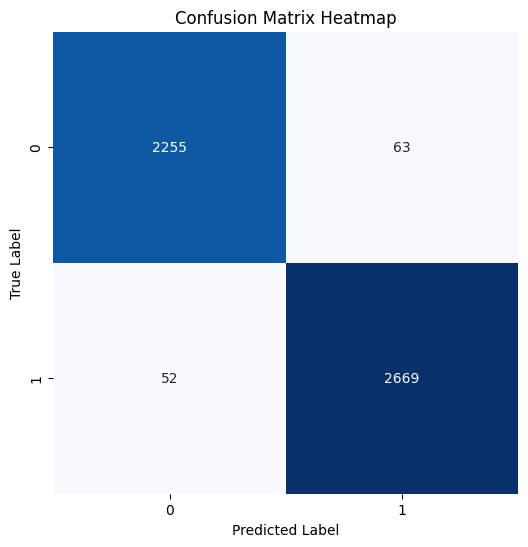

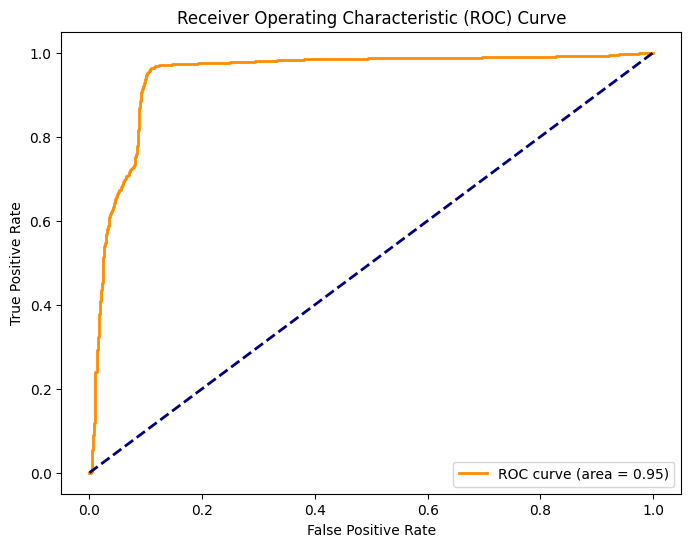


Performance Metrics:
Specificity: 0.9728
FAR: 0.03
Precision: 0.9769
Recall: 0.9809
F1 Score: 0.9789
Accuracy: 0.9772
Training with Adagrad optimizer:
Epoch [1/100], Train Loss: 0.07503508031368256, Test Loss: 0.0777725949883461
Epoch [2/100], Train Loss: 0.07649755477905273, Test Loss: 0.07767525315284729
Epoch [3/100], Train Loss: 0.07923699915409088, Test Loss: 0.07505688071250916
Epoch [4/100], Train Loss: 0.07355984300374985, Test Loss: 0.07555214315652847
Epoch [5/100], Train Loss: 0.07413320988416672, Test Loss: 0.07503161579370499
Epoch [6/100], Train Loss: 0.06960335373878479, Test Loss: 0.07517309486865997
Epoch [7/100], Train Loss: 0.07294319570064545, Test Loss: 0.07493465393781662
Epoch [8/100], Train Loss: 0.07297688722610474, Test Loss: 0.07626718282699585
Epoch [9/100], Train Loss: 0.072508804500103, Test Loss: 0.07591646164655685
Epoch [10/100], Train Loss: 0.0736837238073349, Test Loss: 0.07432875782251358
Epoch [11/100], Train Loss: 0.07178840786218643, Test Loss: 0

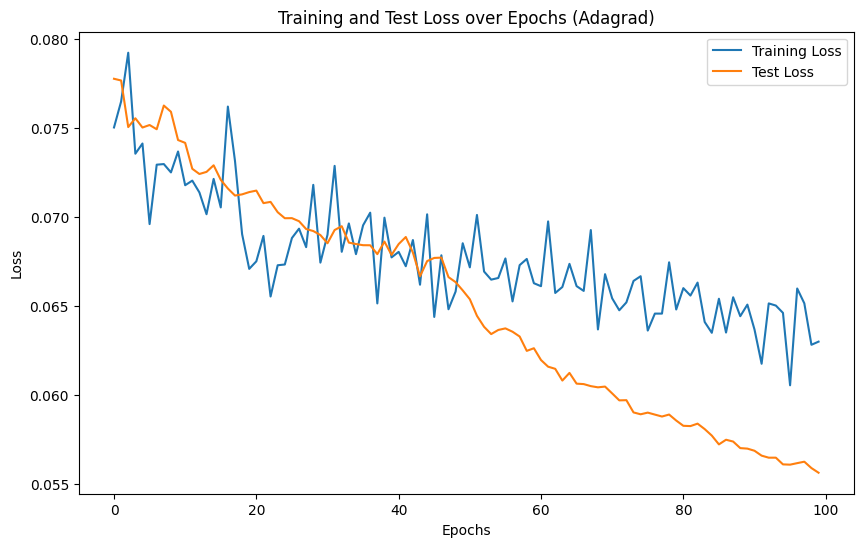

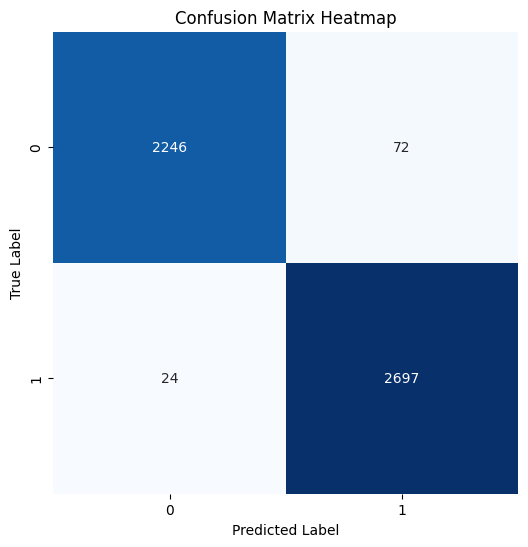

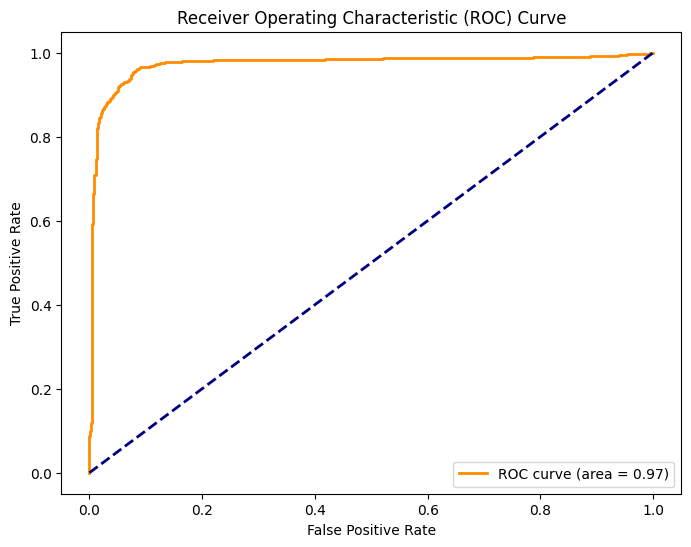


Performance Metrics:
Specificity: 0.9689
FAR: 0.03
Precision: 0.9740
Recall: 0.9912
F1 Score: 0.9825
Accuracy: 0.9809


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)

# Test different optimizers
for optimizer_class in [optim.Adam, optim.SGD, optim.RMSprop, optim.Adagrad]:
    print(f"Training with {optimizer_class.__name__} optimizer:")
    import time
    s = time.time()
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience)
    t = time.time() - s
    print("training time:", t)

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs ({optimizer_class.__name__})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate performance metrics
    conf_mat = confusion_matrix(test_labels, predicted)
    specificity = conf_mat[0, 0] / (conf_mat[0, 0] + conf_mat[0, 1])
    far = conf_mat[0, 1] / (conf_mat[0, 1] + conf_mat[0, 0])
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.4f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("Accuracy: {:.4f}".format(accuracy))


Training with Adagrad optimizer, learning rate: 0.007
Epoch [1/100], Train Loss: 1.605932354927063, Test Loss: 0.6174455881118774
Epoch [2/100], Train Loss: 0.713353157043457, Test Loss: 0.5050687193870544
Epoch [3/100], Train Loss: 0.5064269304275513, Test Loss: 0.5444124937057495
Epoch [4/100], Train Loss: 0.4162701368331909, Test Loss: 0.4862804114818573
Epoch [5/100], Train Loss: 0.36341428756713867, Test Loss: 0.4972647428512573
Epoch [6/100], Train Loss: 0.3219888508319855, Test Loss: 0.4820442199707031
Epoch [7/100], Train Loss: 0.3046487271785736, Test Loss: 0.46693339943885803
Epoch [8/100], Train Loss: 0.2797918915748596, Test Loss: 0.45395925641059875
Epoch [9/100], Train Loss: 0.26700764894485474, Test Loss: 0.43790706992149353
Epoch [10/100], Train Loss: 0.2793586254119873, Test Loss: 0.40506860613822937
Epoch [11/100], Train Loss: 0.24570420384407043, Test Loss: 0.3931279182434082
Epoch [12/100], Train Loss: 0.24952933192253113, Test Loss: 0.36781421303749084
Epoch [13/10

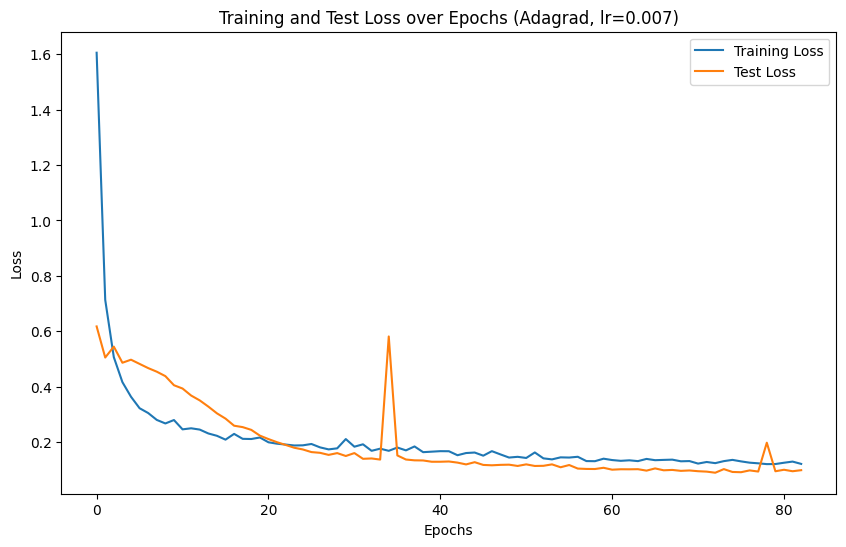

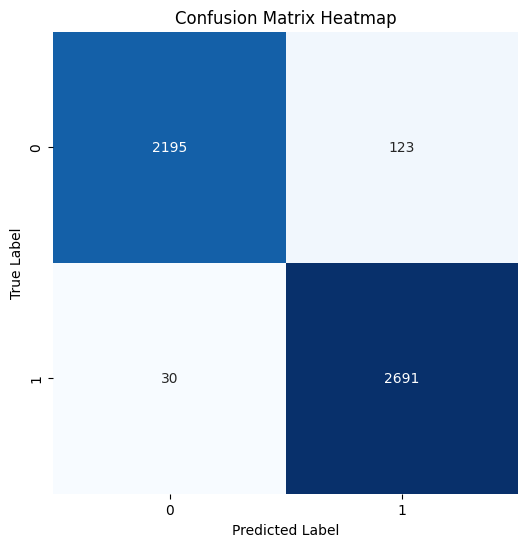

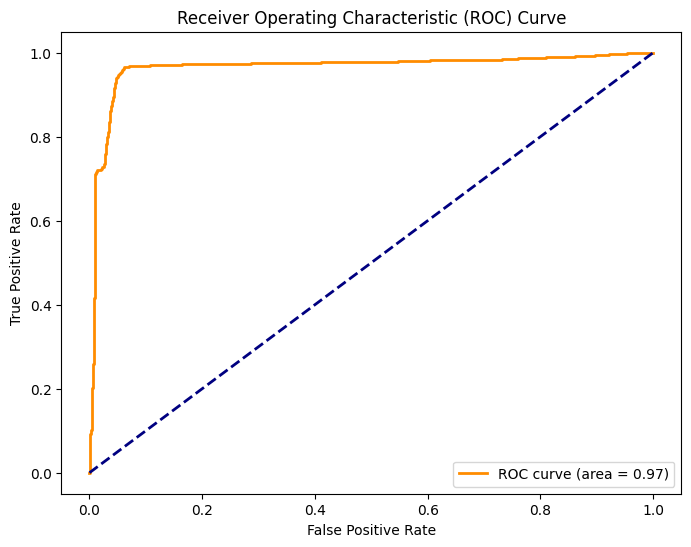


Performance Metrics:
Specificity: 0.9469
FAR: 0.05
Precision: 0.9563
Recall: 0.9890
F1 Score: 0.9724
Accuracy: 0.9696
Training with Adagrad optimizer, learning rate: 0.001
Epoch [1/100], Train Loss: 0.9655420184135437, Test Loss: 0.6902866363525391
Epoch [2/100], Train Loss: 0.5748461484909058, Test Loss: 0.680946409702301
Epoch [3/100], Train Loss: 0.5300455689430237, Test Loss: 0.6724001169204712
Epoch [4/100], Train Loss: 0.45021650195121765, Test Loss: 0.6660168766975403
Epoch [5/100], Train Loss: 0.44678521156311035, Test Loss: 0.6586375832557678
Epoch [6/100], Train Loss: 0.41982582211494446, Test Loss: 0.6494163274765015
Epoch [7/100], Train Loss: 0.40797126293182373, Test Loss: 0.6402289867401123
Epoch [8/100], Train Loss: 0.37895697355270386, Test Loss: 0.6282848119735718
Epoch [9/100], Train Loss: 0.3811856508255005, Test Loss: 0.6175677180290222
Epoch [10/100], Train Loss: 0.38128462433815, Test Loss: 0.6042532920837402
Epoch [11/100], Train Loss: 0.3740370571613312, Test L

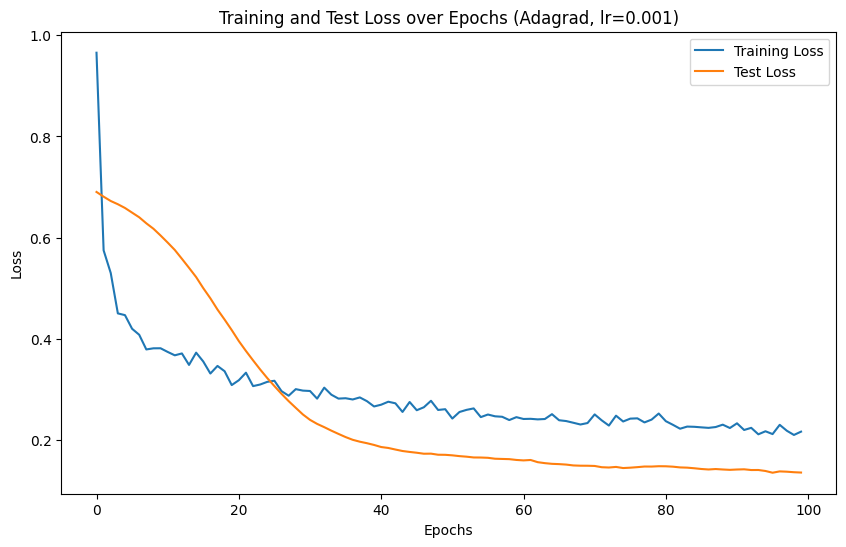

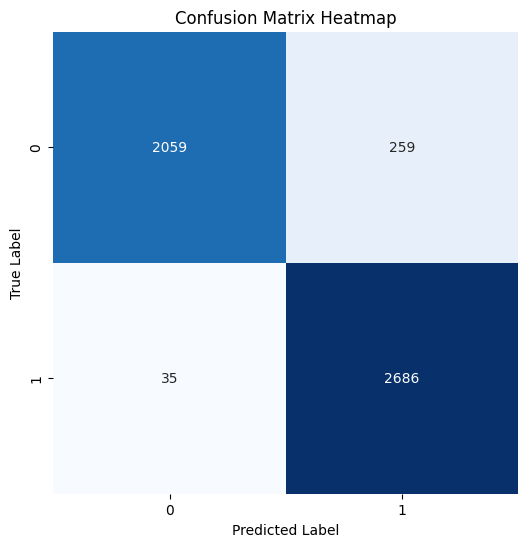

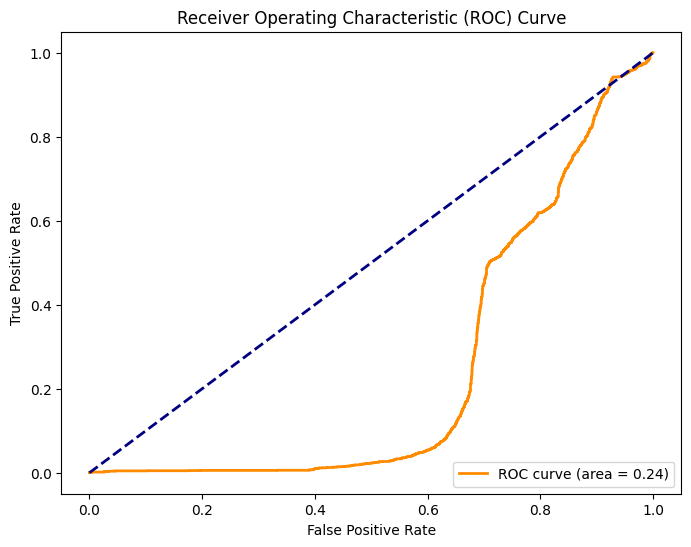


Performance Metrics:
Specificity: 0.8883
FAR: 0.11
Precision: 0.9121
Recall: 0.9871
F1 Score: 0.9481
Accuracy: 0.9417
Training with Adagrad optimizer, learning rate: 0.002
Epoch [1/100], Train Loss: 1.3608531951904297, Test Loss: 0.6748424172401428
Epoch [2/100], Train Loss: 0.6864606142044067, Test Loss: 0.6353268027305603
Epoch [3/100], Train Loss: 0.5341170430183411, Test Loss: 0.6324535012245178
Epoch [4/100], Train Loss: 0.47805076837539673, Test Loss: 0.6204171180725098
Epoch [5/100], Train Loss: 0.4445396959781647, Test Loss: 0.6054859161376953
Epoch [6/100], Train Loss: 0.41154173016548157, Test Loss: 0.5902542471885681
Epoch [7/100], Train Loss: 0.40502649545669556, Test Loss: 0.5761277079582214
Epoch [8/100], Train Loss: 0.36172837018966675, Test Loss: 0.5598297715187073
Epoch [9/100], Train Loss: 0.34710273146629333, Test Loss: 0.5450370907783508
Epoch [10/100], Train Loss: 0.344108521938324, Test Loss: 0.5234736800193787
Epoch [11/100], Train Loss: 0.33088913559913635, Tes

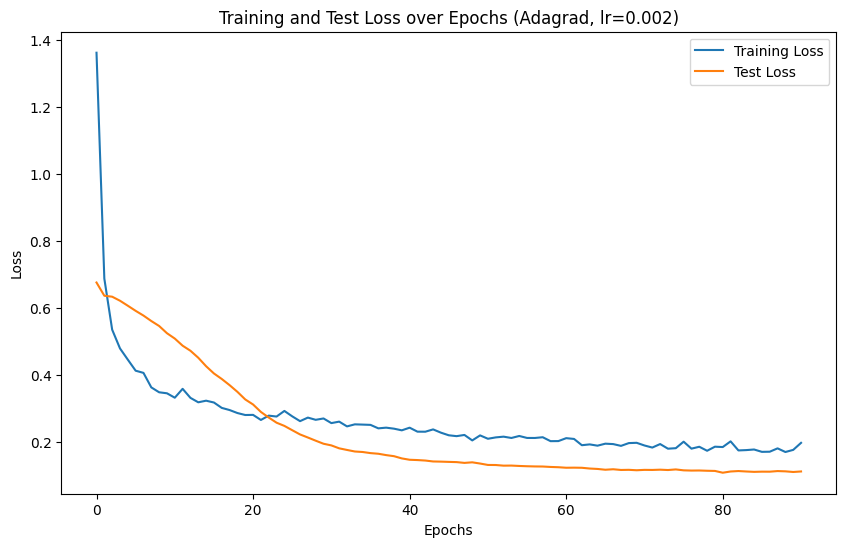

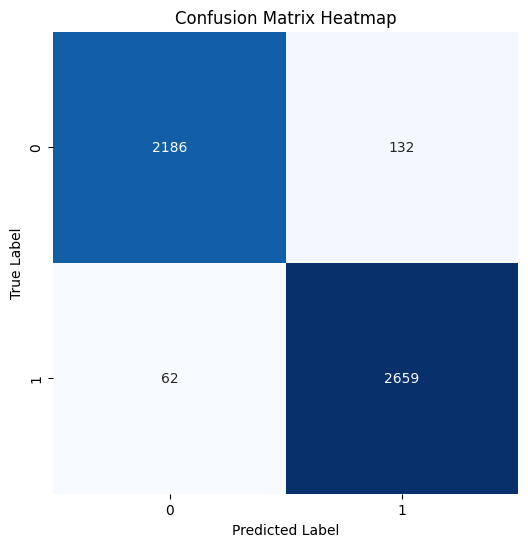

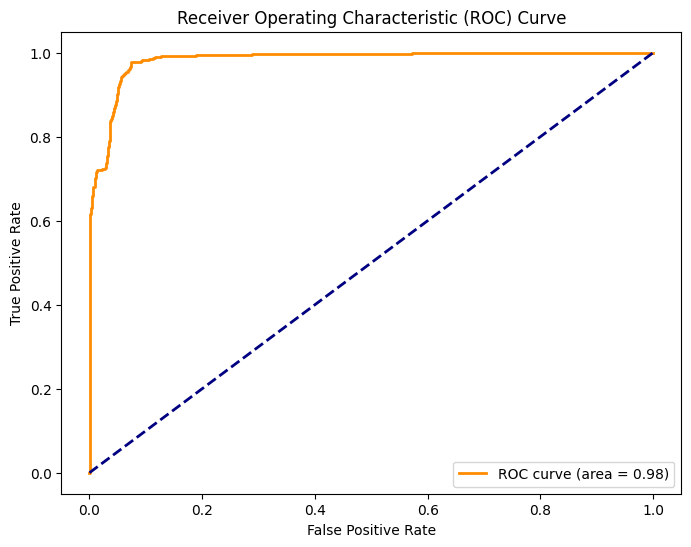


Performance Metrics:
Specificity: 0.9431
FAR: 0.06
Precision: 0.9527
Recall: 0.9772
F1 Score: 0.9648
Accuracy: 0.9615
Training with Adagrad optimizer, learning rate: 0.0025
Epoch [1/100], Train Loss: 1.4611670970916748, Test Loss: 0.622278094291687
Epoch [2/100], Train Loss: 0.4847400188446045, Test Loss: 0.6338458061218262
Epoch [3/100], Train Loss: 0.4353170394897461, Test Loss: 0.6308221220970154
Epoch [4/100], Train Loss: 0.39370211958885193, Test Loss: 0.6293867826461792
Epoch [5/100], Train Loss: 0.36793652176856995, Test Loss: 0.6257383823394775
Epoch [6/100], Train Loss: 0.3836808204650879, Test Loss: 0.6219127774238586
Epoch [7/100], Train Loss: 0.3390904664993286, Test Loss: 0.6117308139801025
Epoch [8/100], Train Loss: 0.3290562331676483, Test Loss: 0.6001071333885193
Epoch [9/100], Train Loss: 0.3356865346431732, Test Loss: 0.5817862153053284
Epoch [10/100], Train Loss: 0.34930360317230225, Test Loss: 0.5660086274147034
Epoch [11/100], Train Loss: 0.32626667618751526, Test

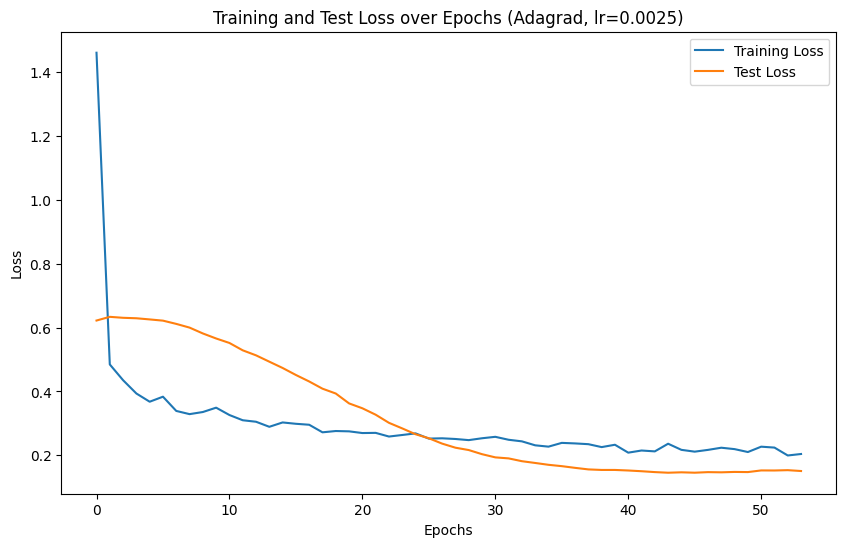

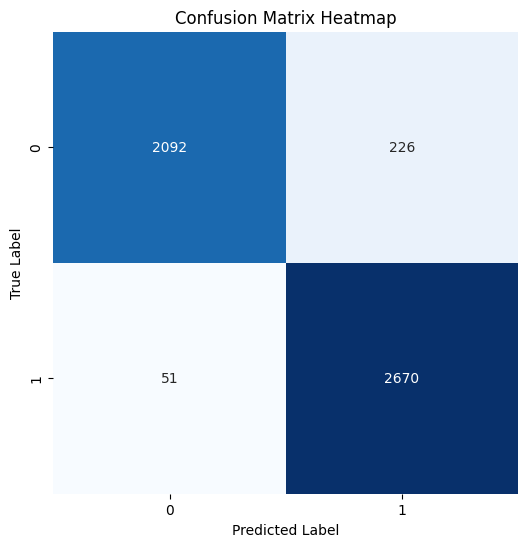

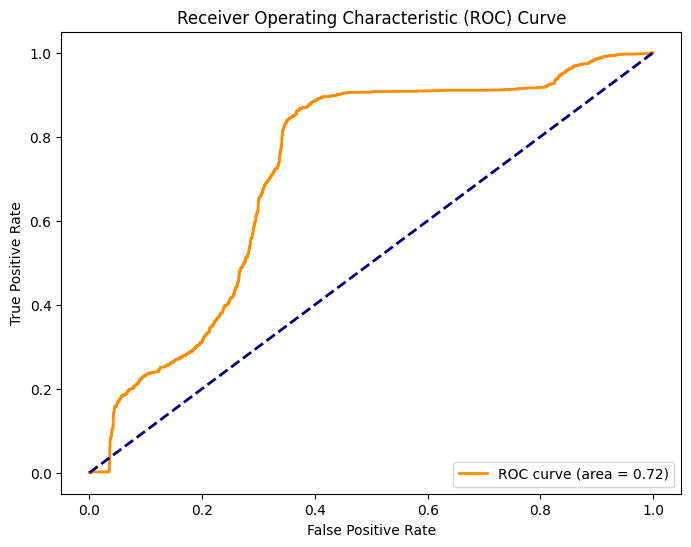


Performance Metrics:
Specificity: 0.9025
FAR: 0.10
Precision: 0.9220
Recall: 0.9813
F1 Score: 0.9507
Accuracy: 0.9450


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
patience = 10

learning_rates = [0.007, 0.001, 0.002, 0.0025]

for learning_rate in learning_rates:
    print(f"Training with Adagrad optimizer, learning rate: {learning_rate}")
    import time
    s = time.time()
    snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optim.Adagrad, patience)
    t = time.time() - s
    print("training time:", t)

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs (Adagrad, lr={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate performance metrics
    conf_mat = confusion_matrix(test_labels, predicted)
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    specificity = TN / (TN + FP)
    far = FP / (FP + TN)
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.4f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("Accuracy: {:.4f}".format(accuracy))

Training with Adagrad optimizer, learning rate: 0.007
Epoch [1/100], Train Loss: 1.2166364192962646, Test Loss: 0.6125744581222534
Epoch [2/100], Train Loss: 0.642013669013977, Test Loss: 0.5619913339614868
Epoch [3/100], Train Loss: 0.42516711354255676, Test Loss: 0.6058486700057983
Epoch [4/100], Train Loss: 0.3406432271003723, Test Loss: 0.5708202719688416
Epoch [5/100], Train Loss: 0.34434694051742554, Test Loss: 0.6030285954475403
Epoch [6/100], Train Loss: 0.3232306241989136, Test Loss: 0.5709182024002075
Epoch [7/100], Train Loss: 0.2652401328086853, Test Loss: 0.5578100681304932
Epoch [8/100], Train Loss: 0.2653855085372925, Test Loss: 0.5473443865776062
Epoch [9/100], Train Loss: 0.25301337242126465, Test Loss: 0.5181128978729248
Epoch [10/100], Train Loss: 0.23579943180084229, Test Loss: 0.5175342559814453
Epoch [11/100], Train Loss: 0.22808098793029785, Test Loss: 0.4968279302120209
Epoch [12/100], Train Loss: 0.23389388620853424, Test Loss: 0.46087685227394104
Epoch [13/100

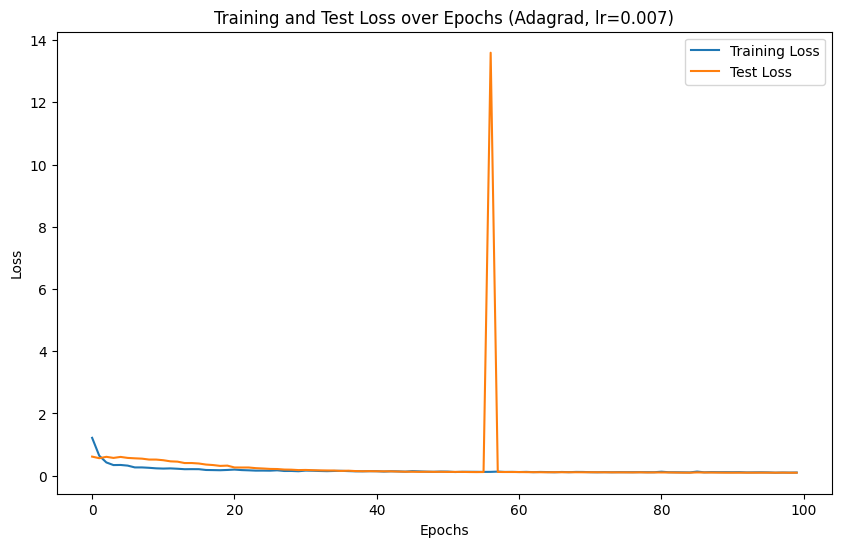

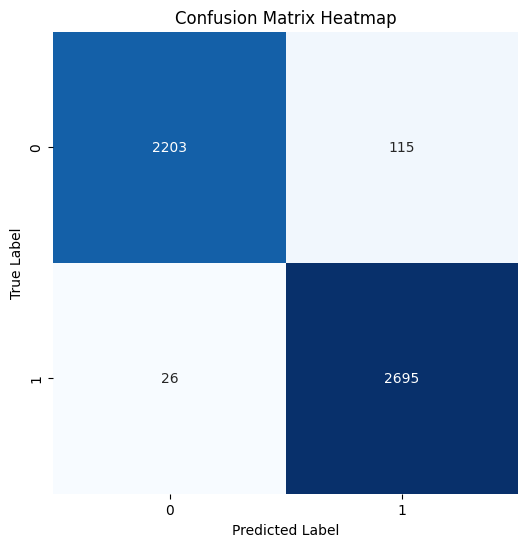

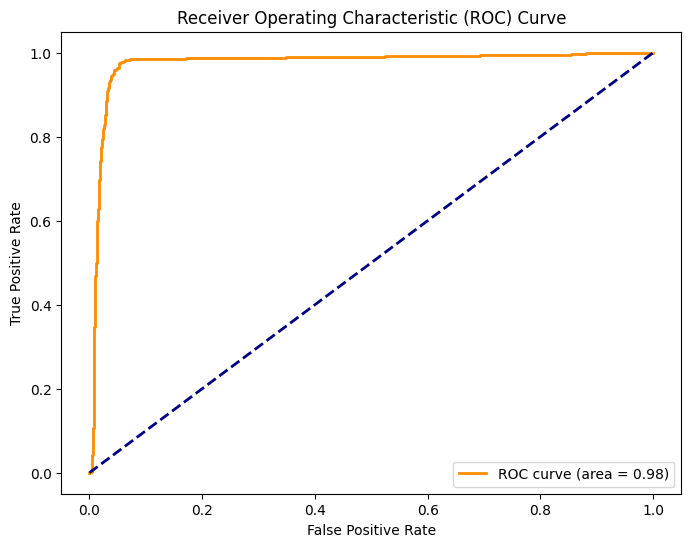


Performance Metrics:
Specificity: 0.9504
FAR: 0.05
Precision: 0.9591
Recall: 0.9904
F1 Score: 0.9745
Accuracy: 0.9720
Training with Adagrad optimizer, learning rate: 0.001
Epoch [1/100], Train Loss: 1.3874226808547974, Test Loss: 0.6775891184806824
Epoch [2/100], Train Loss: 0.7856637239456177, Test Loss: 0.6719830632209778
Epoch [3/100], Train Loss: 0.6809370517730713, Test Loss: 0.6654404997825623
Epoch [4/100], Train Loss: 0.5971797108650208, Test Loss: 0.6611827611923218
Epoch [5/100], Train Loss: 0.5932117104530334, Test Loss: 0.6537020802497864
Epoch [6/100], Train Loss: 0.5067514181137085, Test Loss: 0.6484616994857788
Epoch [7/100], Train Loss: 0.5086521506309509, Test Loss: 0.6417805552482605
Epoch [8/100], Train Loss: 0.48048222064971924, Test Loss: 0.6315286159515381
Epoch [9/100], Train Loss: 0.4738311469554901, Test Loss: 0.6222281455993652
Epoch [10/100], Train Loss: 0.4631821811199188, Test Loss: 0.6139019727706909
Epoch [11/100], Train Loss: 0.44719865918159485, Test L

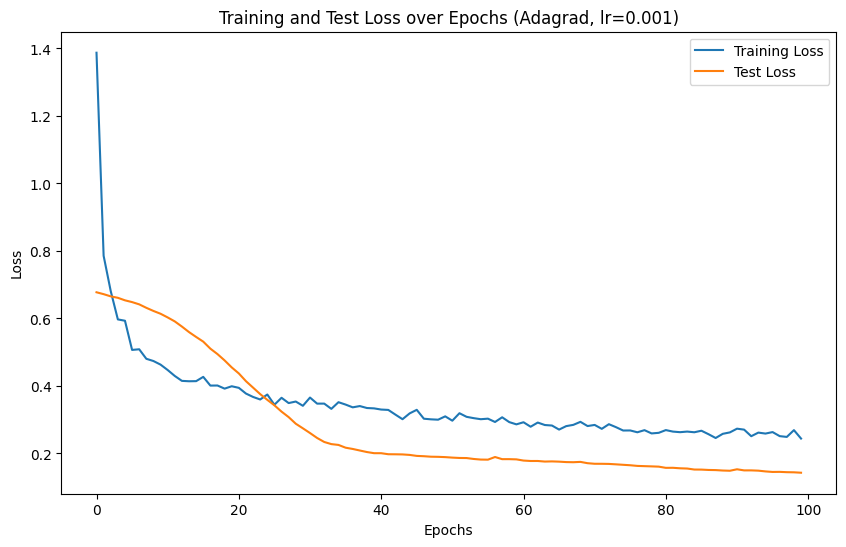

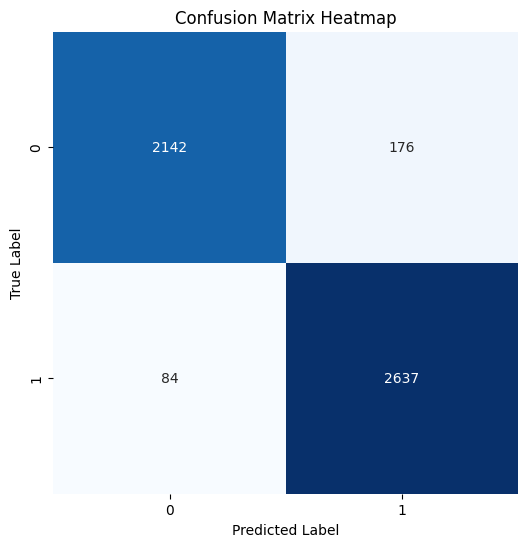

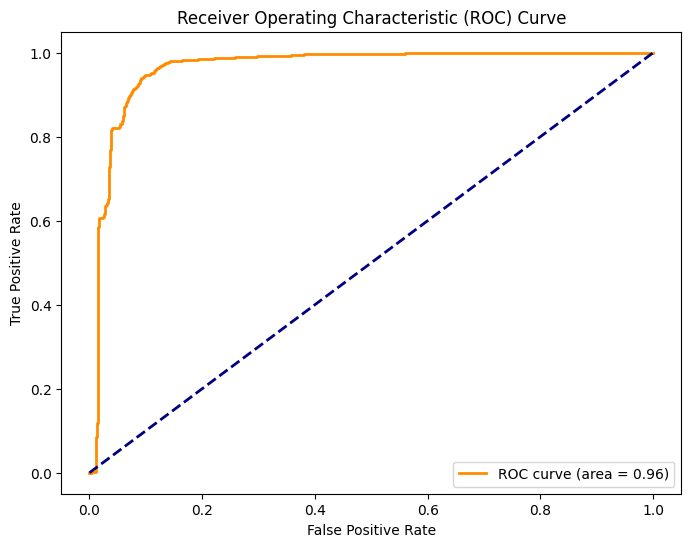


Performance Metrics:
Specificity: 0.9241
FAR: 0.08
Precision: 0.9374
Recall: 0.9691
F1 Score: 0.9530
Accuracy: 0.9484
Training with Adagrad optimizer, learning rate: 0.002
Epoch [1/100], Train Loss: 1.228836178779602, Test Loss: 0.7184507250785828
Epoch [2/100], Train Loss: 0.5895684361457825, Test Loss: 0.7095451354980469
Epoch [3/100], Train Loss: 0.4590454399585724, Test Loss: 0.7007735371589661
Epoch [4/100], Train Loss: 0.40508973598480225, Test Loss: 0.6914187073707581
Epoch [5/100], Train Loss: 0.3751128315925598, Test Loss: 0.6820903420448303
Epoch [6/100], Train Loss: 0.361355185508728, Test Loss: 0.6725914478302002
Epoch [7/100], Train Loss: 0.34601011872291565, Test Loss: 0.6606134176254272
Epoch [8/100], Train Loss: 0.33792614936828613, Test Loss: 0.6487948894500732
Epoch [9/100], Train Loss: 0.3228965699672699, Test Loss: 0.6361497640609741
Epoch [10/100], Train Loss: 0.3304768204689026, Test Loss: 0.6229402422904968
Epoch [11/100], Train Loss: 0.3173370063304901, Test Lo

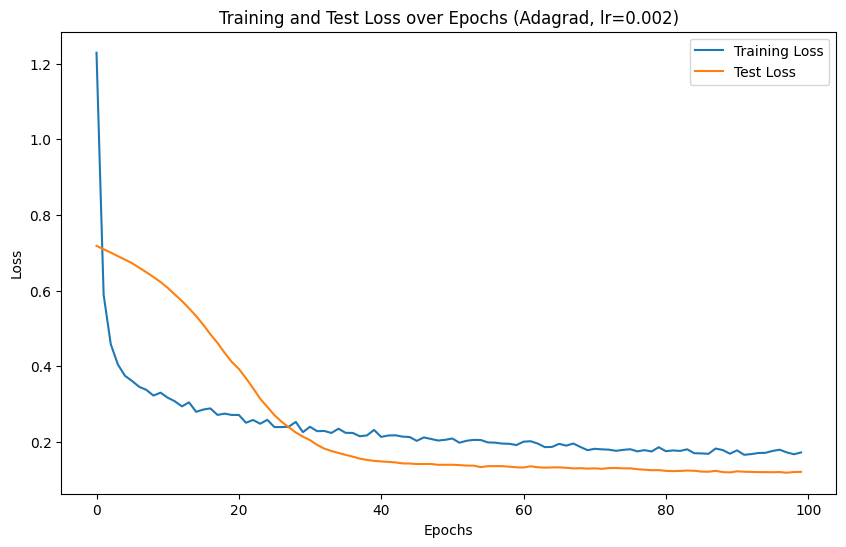

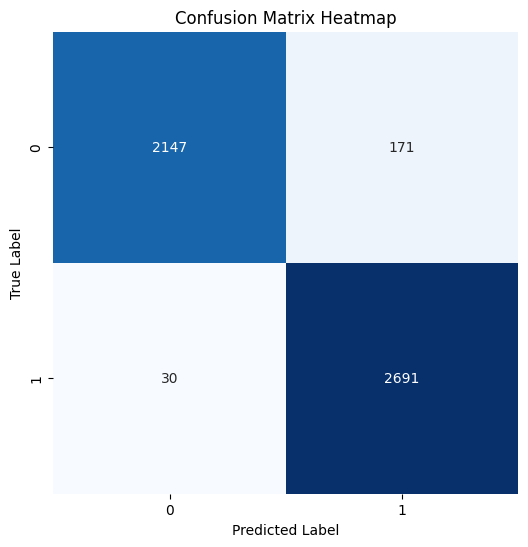

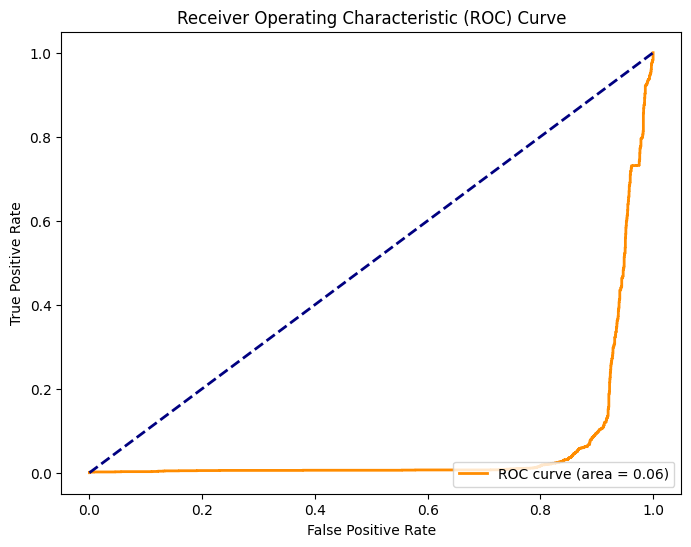


Performance Metrics:
Specificity: 0.9262
FAR: 0.07
Precision: 0.9403
Recall: 0.9890
F1 Score: 0.9640
Accuracy: 0.9601
Training with Adagrad optimizer, learning rate: 0.0025
Epoch [1/100], Train Loss: 1.253899097442627, Test Loss: 0.683014452457428
Epoch [2/100], Train Loss: 0.6062828302383423, Test Loss: 0.6791781187057495
Epoch [3/100], Train Loss: 0.5156380534172058, Test Loss: 0.6704756617546082
Epoch [4/100], Train Loss: 0.460335910320282, Test Loss: 0.663036048412323
Epoch [5/100], Train Loss: 0.4065590500831604, Test Loss: 0.6572534441947937
Epoch [6/100], Train Loss: 0.40272602438926697, Test Loss: 0.6437523365020752
Epoch [7/100], Train Loss: 0.3976433575153351, Test Loss: 0.6375682950019836
Epoch [8/100], Train Loss: 0.3645234704017639, Test Loss: 0.6222993731498718
Epoch [9/100], Train Loss: 0.34374716877937317, Test Loss: 0.6074701547622681
Epoch [10/100], Train Loss: 0.34919002652168274, Test Loss: 0.5946940779685974
Epoch [11/100], Train Loss: 0.32931801676750183, Test Lo

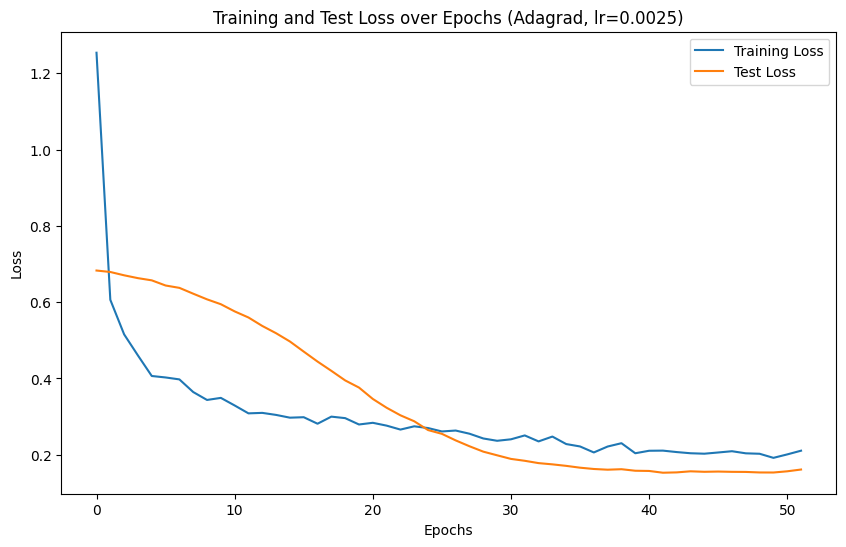

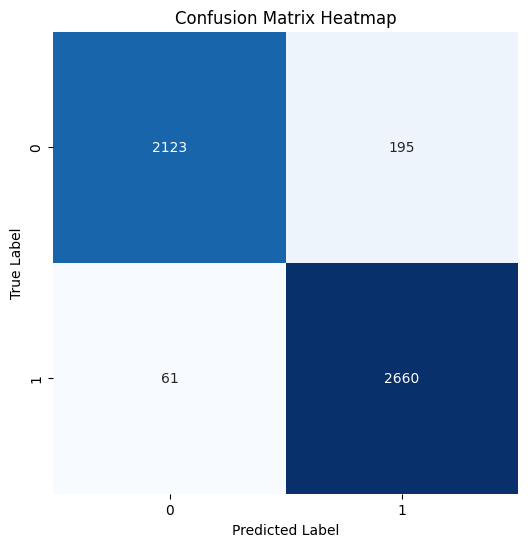

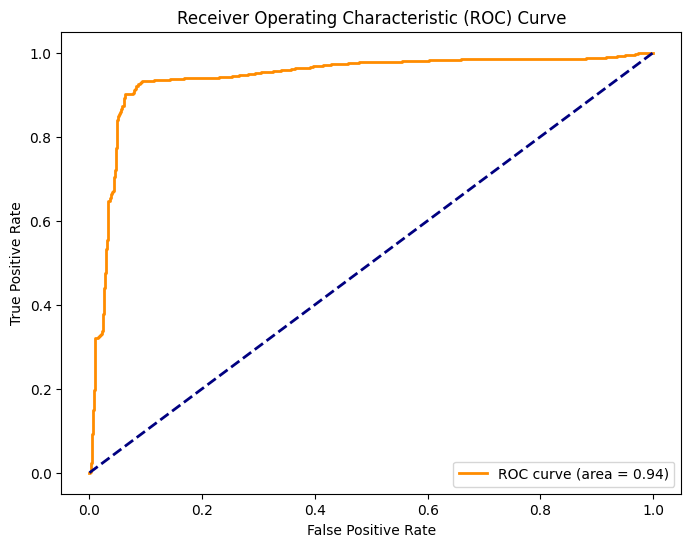


Performance Metrics:
Specificity: 0.9159
FAR: 0.08
Precision: 0.9317
Recall: 0.9776
F1 Score: 0.9541
Accuracy: 0.9492


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout3(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout2(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
patience = 10

learning_rates = [0.007, 0.001, 0.002, 0.0025]

for learning_rate in learning_rates:
    print(f"Training with Adagrad optimizer, learning rate: {learning_rate}")
    import time
    s = time.time()
    snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optim.Adagrad, patience)
    t = time.time() - s
    print("training time:", t)

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs (Adagrad, lr={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate performance metrics
    conf_mat = confusion_matrix(test_labels, predicted)
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    specificity = TN / (TN + FP)
    far = FP / (FP + TN)
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.4f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("Accuracy: {:.4f}".format(accuracy))

far 0.03
adagrad 0.0025

Training with Adagrad optimizer, learning rate: 0.002
Epoch [1/100], Train Loss: 1.187876582145691, Test Loss: 0.6859965324401855
Epoch [2/100], Train Loss: 0.6168920397758484, Test Loss: 0.6482409834861755
Epoch [3/100], Train Loss: 0.5138501524925232, Test Loss: 0.6334881782531738
Epoch [4/100], Train Loss: 0.4890069365501404, Test Loss: 0.6184341311454773
Epoch [5/100], Train Loss: 0.4052334129810333, Test Loss: 0.6035022735595703
Epoch [6/100], Train Loss: 0.39302486181259155, Test Loss: 0.5883564352989197
Epoch [7/100], Train Loss: 0.3879542052745819, Test Loss: 0.5720900297164917
Epoch [8/100], Train Loss: 0.33369651436805725, Test Loss: 0.5565825700759888
Epoch [9/100], Train Loss: 0.3395371735095978, Test Loss: 0.5418919920921326
Epoch [10/100], Train Loss: 0.3351006507873535, Test Loss: 0.5274435877799988
Epoch [11/100], Train Loss: 0.331594318151474, Test Loss: 0.5128375887870789
Epoch [12/100], Train Loss: 0.3127131760120392, Test Loss: 0.4972228407859802
Epoch [13/100], Tra

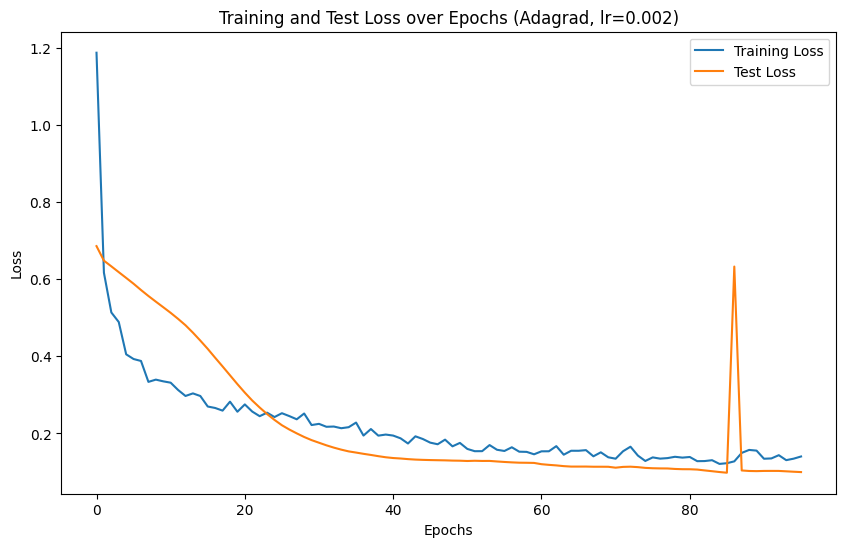

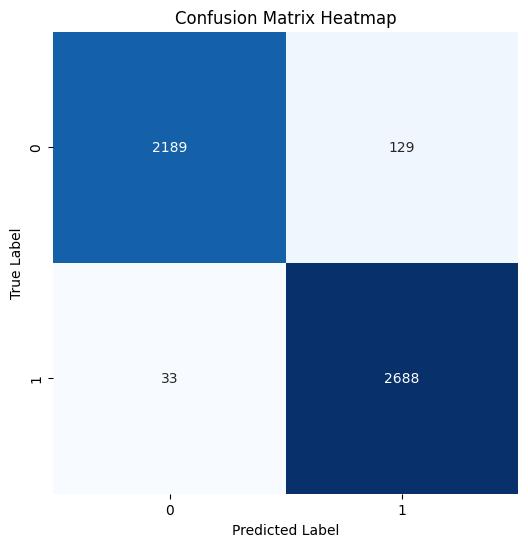

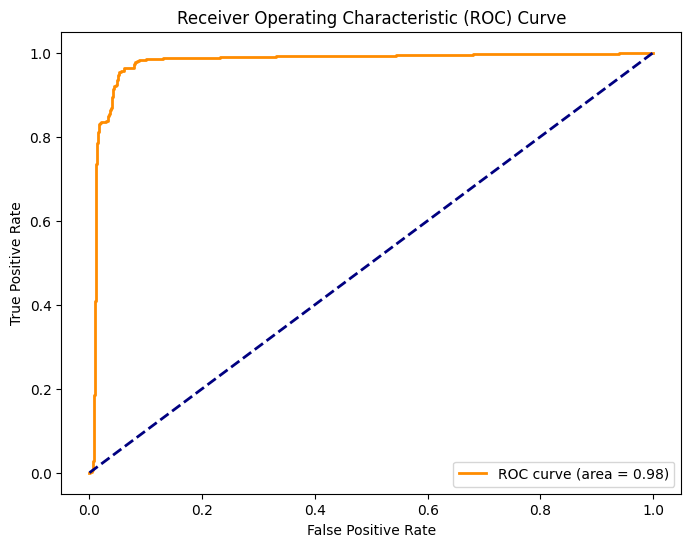


Performance Metrics:
Specificity: 0.9443
FAR: 0.06
Precision: 0.9542
Recall: 0.9879
F1 Score: 0.9707
Accuracy: 0.9679
Training with Adagrad optimizer, learning rate: 0.001
Epoch [1/100], Train Loss: 1.4100450277328491, Test Loss: 0.6934715509414673
Epoch [2/100], Train Loss: 0.6641548275947571, Test Loss: 0.6734641194343567
Epoch [3/100], Train Loss: 0.5397666692733765, Test Loss: 0.6567146182060242
Epoch [4/100], Train Loss: 0.469475120306015, Test Loss: 0.6409247517585754
Epoch [5/100], Train Loss: 0.44124066829681396, Test Loss: 0.6249505877494812
Epoch [6/100], Train Loss: 0.41757532954216003, Test Loss: 0.608989417552948
Epoch [7/100], Train Loss: 0.38366127014160156, Test Loss: 0.5925806164741516
Epoch [8/100], Train Loss: 0.3707113265991211, Test Loss: 0.5753958225250244
Epoch [9/100], Train Loss: 0.3606068193912506, Test Loss: 0.5571335554122925
Epoch [10/100], Train Loss: 0.3657000660896301, Test Loss: 0.5378428101539612
Epoch [11/100], Train Loss: 0.3574671447277069, Test Lo

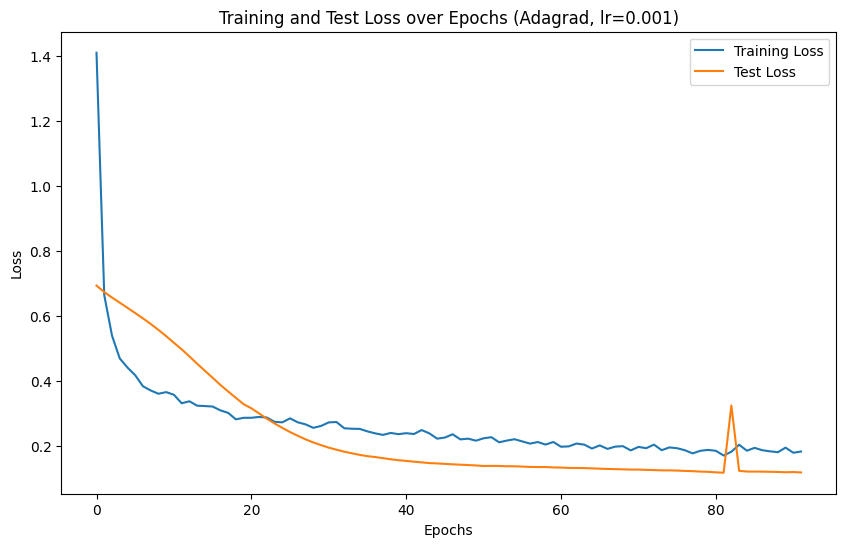

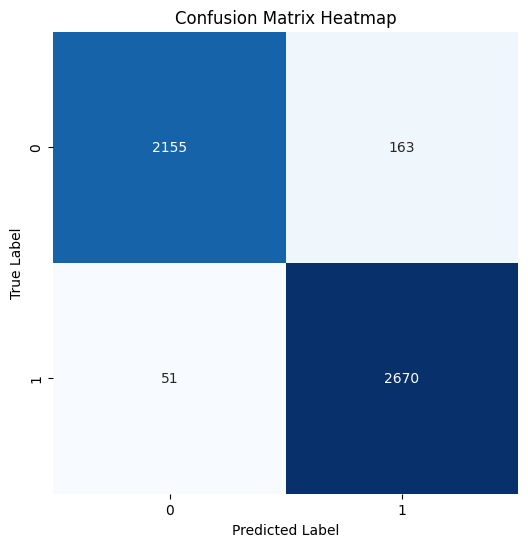

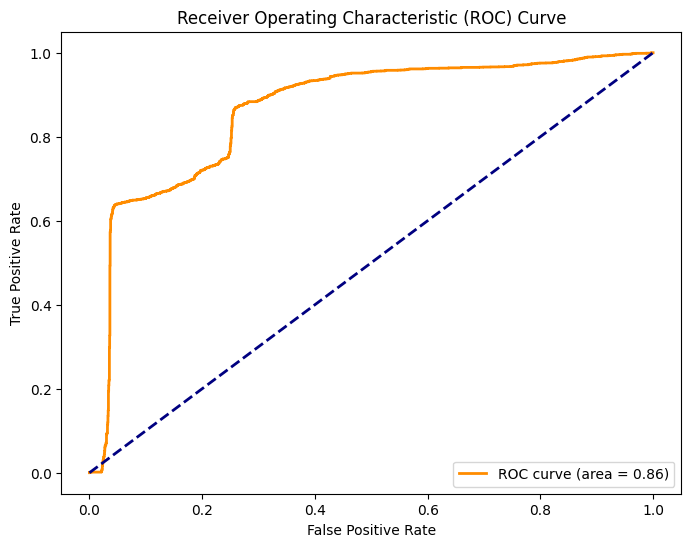


Performance Metrics:
Specificity: 0.9297
FAR: 0.07
Precision: 0.9425
Recall: 0.9813
F1 Score: 0.9615
Accuracy: 0.9575
Training with Adagrad optimizer, learning rate: 0.002
Epoch [1/100], Train Loss: 1.2669854164123535, Test Loss: 0.6312780976295471
Epoch [2/100], Train Loss: 0.6188199520111084, Test Loss: 0.6004478335380554
Epoch [3/100], Train Loss: 0.5205994844436646, Test Loss: 0.5762424468994141
Epoch [4/100], Train Loss: 0.44786500930786133, Test Loss: 0.5563122630119324
Epoch [5/100], Train Loss: 0.3984037935733795, Test Loss: 0.5373979210853577
Epoch [6/100], Train Loss: 0.4045107662677765, Test Loss: 0.51963871717453
Epoch [7/100], Train Loss: 0.38429805636405945, Test Loss: 0.5038644671440125
Epoch [8/100], Train Loss: 0.3658389449119568, Test Loss: 0.4894530177116394
Epoch [9/100], Train Loss: 0.3564396798610687, Test Loss: 0.47525903582572937
Epoch [10/100], Train Loss: 0.3202023208141327, Test Loss: 0.4608147144317627
Epoch [11/100], Train Loss: 0.33199557662010193, Test L

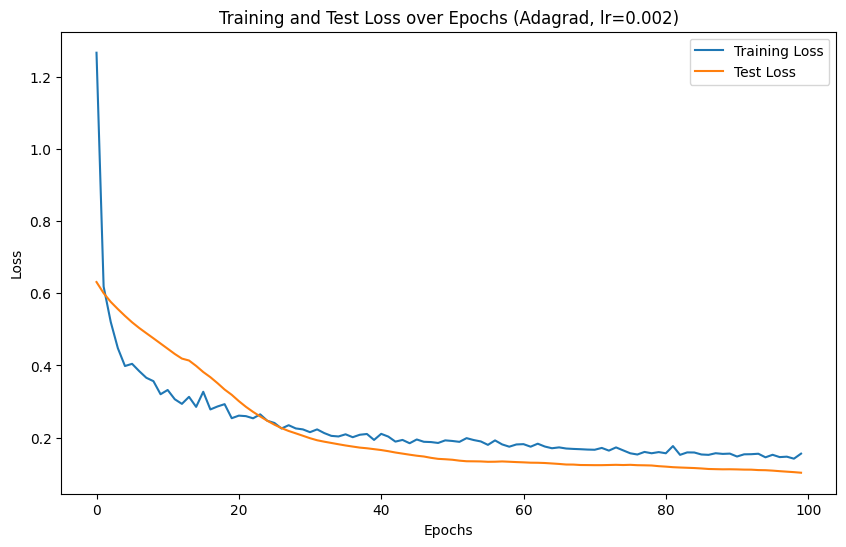

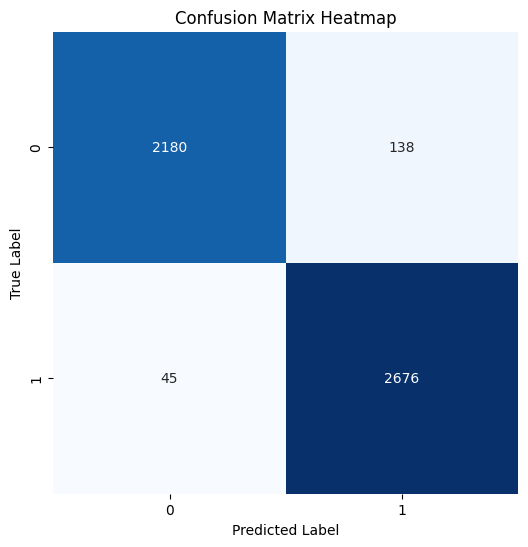

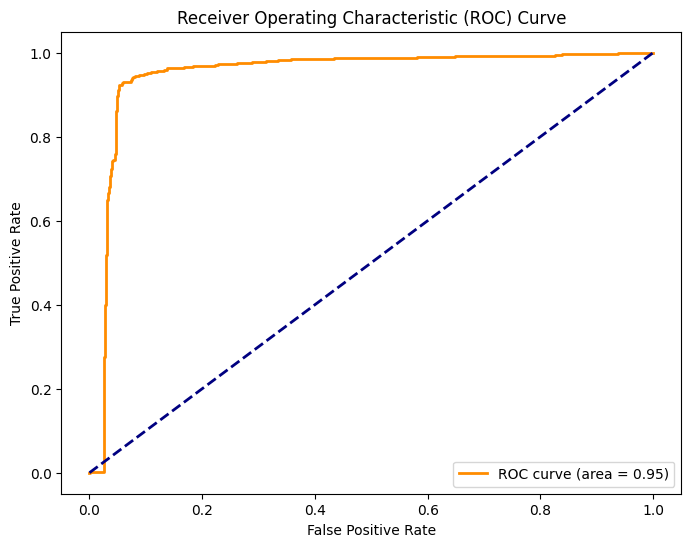


Performance Metrics:
Specificity: 0.9405
FAR: 0.06
Precision: 0.9510
Recall: 0.9835
F1 Score: 0.9669
Accuracy: 0.9637
Training with Adagrad optimizer, learning rate: 0.0025
Epoch [1/100], Train Loss: 0.9909579157829285, Test Loss: 0.6346777081489563
Epoch [2/100], Train Loss: 0.5464340448379517, Test Loss: 0.596343994140625
Epoch [3/100], Train Loss: 0.4608202278614044, Test Loss: 0.576336145401001
Epoch [4/100], Train Loss: 0.42678752541542053, Test Loss: 0.557482898235321
Epoch [5/100], Train Loss: 0.4003807008266449, Test Loss: 0.5391797423362732
Epoch [6/100], Train Loss: 0.36009132862091064, Test Loss: 0.5207787156105042
Epoch [7/100], Train Loss: 0.33452722430229187, Test Loss: 0.5042434930801392
Epoch [8/100], Train Loss: 0.3244266211986542, Test Loss: 0.4874226152896881
Epoch [9/100], Train Loss: 0.31016385555267334, Test Loss: 0.471456915140152
Epoch [10/100], Train Loss: 0.299075722694397, Test Loss: 0.4551979899406433
Epoch [11/100], Train Loss: 0.2844301760196686, Test Los

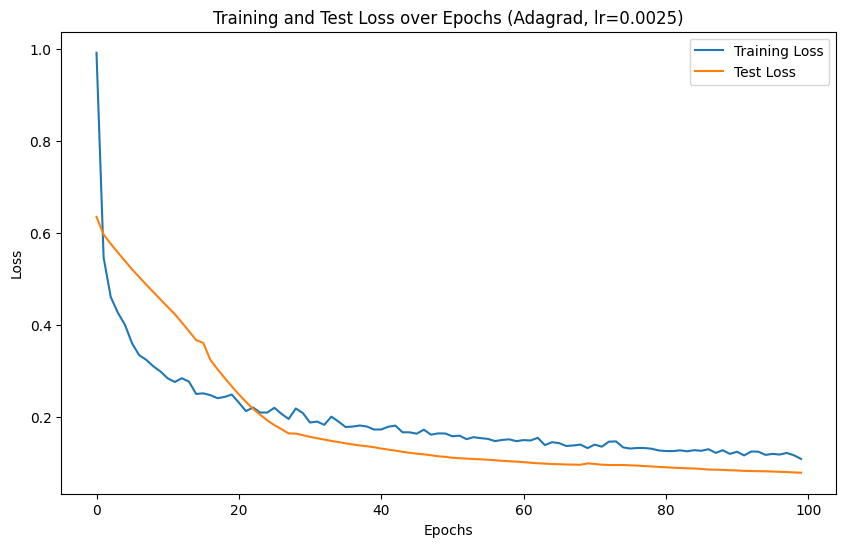

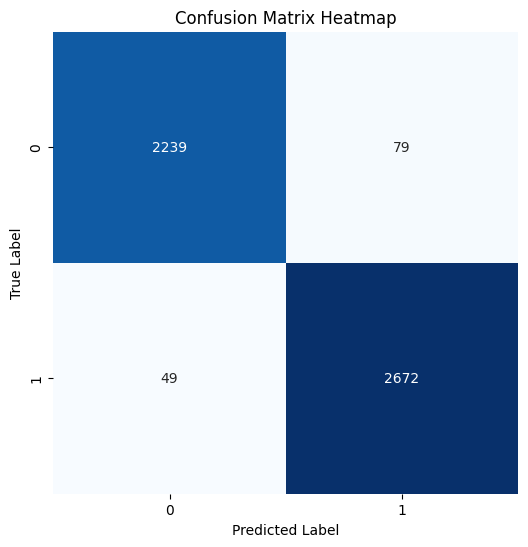

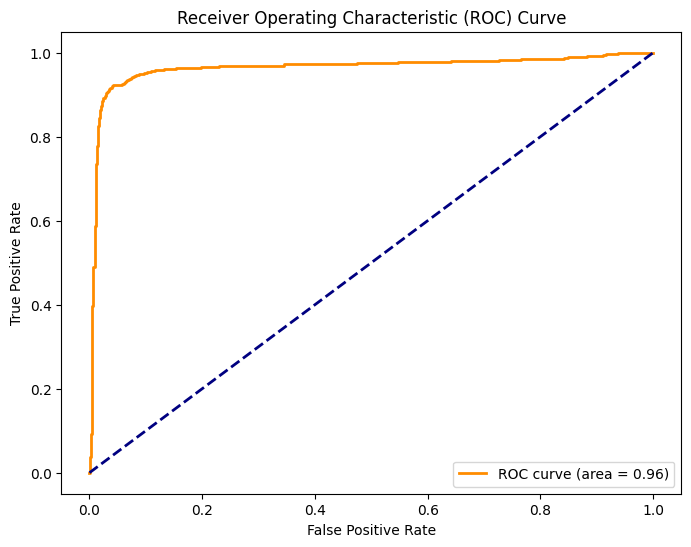


Performance Metrics:
Specificity: 0.9659
FAR: 0.03
Precision: 0.9713
Recall: 0.9820
F1 Score: 0.9766
Accuracy: 0.9746


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
patience = 10

learning_rates = [0.002, 0.001, 0.002, 0.0025]

for learning_rate in learning_rates:
    print(f"Training with Adagrad optimizer, learning rate: {learning_rate}")
    import time
    s = time.time()
    snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optim.Adamax, patience)
    t = time.time() - s
    print("training time:", t)

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs (Adagrad, lr={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate performance metrics
    conf_mat = confusion_matrix(test_labels, predicted)
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    specificity = TN / (TN + FP)
    far = FP / (FP + TN)
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.4f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("Accuracy: {:.4f}".format(accuracy))

Training with Adagrad optimizer, learning rate: 0.002
Epoch [1/100], Train Loss: 0.9479755163192749, Test Loss: 0.6890906095504761
Epoch [2/100], Train Loss: 0.662459135055542, Test Loss: 0.6876152753829956
Epoch [3/100], Train Loss: 0.6266998648643494, Test Loss: 0.6857811808586121
Epoch [4/100], Train Loss: 0.536705732345581, Test Loss: 0.6839177012443542
Epoch [5/100], Train Loss: 0.5394302010536194, Test Loss: 0.6822116374969482
Epoch [6/100], Train Loss: 0.48937472701072693, Test Loss: 0.6805758476257324
Epoch [7/100], Train Loss: 0.47879523038864136, Test Loss: 0.6794434189796448
Epoch [8/100], Train Loss: 0.4501785933971405, Test Loss: 0.6785256266593933
Epoch [9/100], Train Loss: 0.4453488886356354, Test Loss: 0.67740797996521
Epoch [10/100], Train Loss: 0.41842690110206604, Test Loss: 0.6758178472518921
Epoch [11/100], Train Loss: 0.40900203585624695, Test Loss: 0.6737384796142578
Epoch [12/100], Train Loss: 0.4110720455646515, Test Loss: 0.6712884306907654
Epoch [13/100], Tra

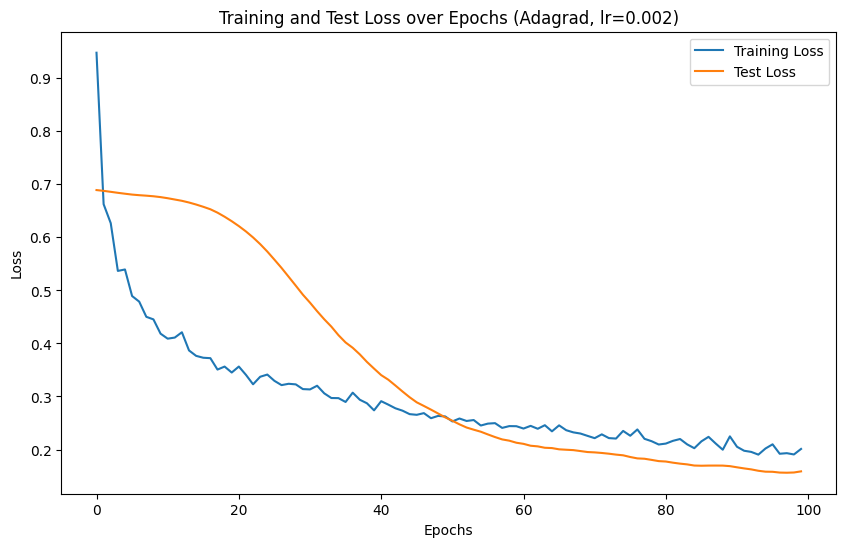

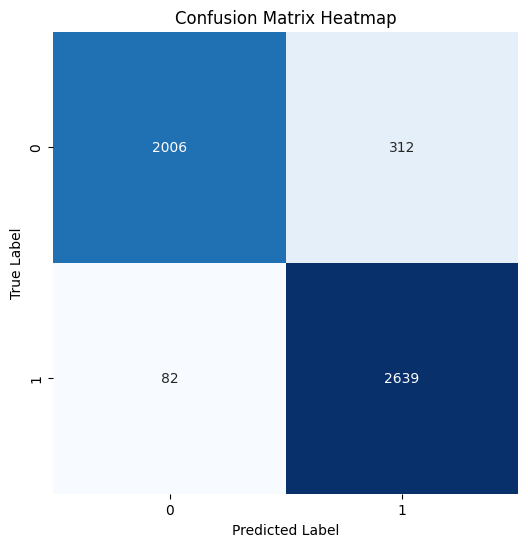

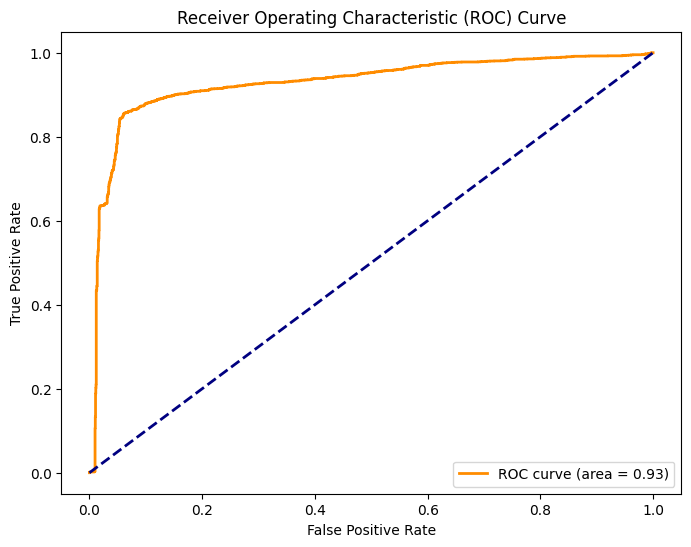


Performance Metrics:
Specificity: 0.8654
FAR: 0.13
Precision: 0.8943
Recall: 0.9699
F1 Score: 0.9305
Accuracy: 0.9218
Training with Adagrad optimizer, learning rate: 0.001
Epoch [1/100], Train Loss: 1.0218465328216553, Test Loss: 0.7279450297355652
Epoch [2/100], Train Loss: 0.8184810876846313, Test Loss: 0.7252070307731628
Epoch [3/100], Train Loss: 0.7533397078514099, Test Loss: 0.72316974401474
Epoch [4/100], Train Loss: 0.7536401748657227, Test Loss: 0.7217678427696228
Epoch [5/100], Train Loss: 0.6955839991569519, Test Loss: 0.7201554179191589
Epoch [6/100], Train Loss: 0.6783872842788696, Test Loss: 0.7180113196372986
Epoch [7/100], Train Loss: 0.6537477970123291, Test Loss: 0.7157434821128845
Epoch [8/100], Train Loss: 0.654793381690979, Test Loss: 0.7135822772979736
Epoch [9/100], Train Loss: 0.6217448711395264, Test Loss: 0.7106766700744629
Epoch [10/100], Train Loss: 0.5836415886878967, Test Loss: 0.7078495025634766
Epoch [11/100], Train Loss: 0.5845319628715515, Test Loss: 

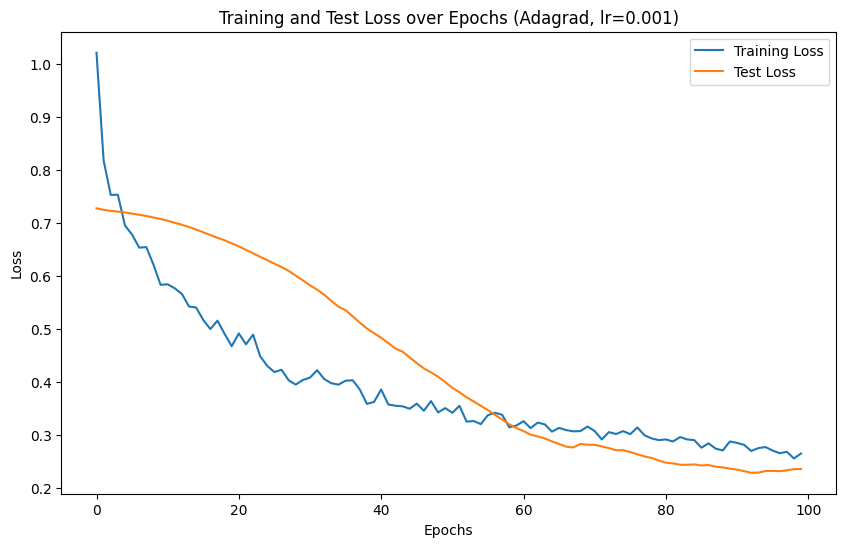

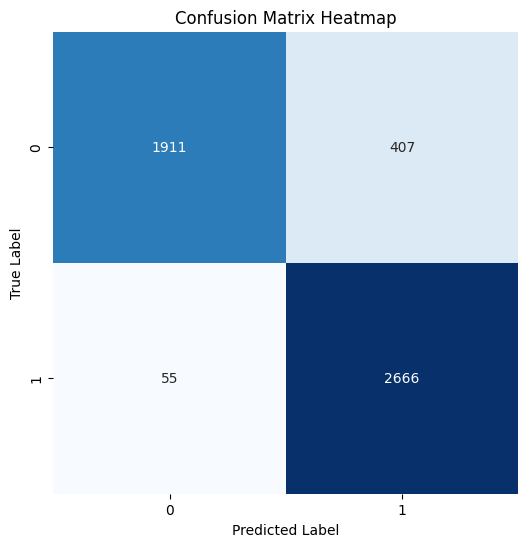

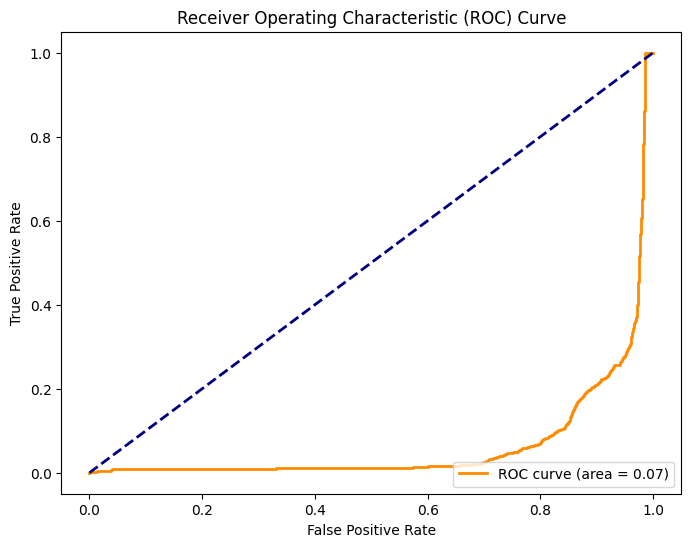


Performance Metrics:
Specificity: 0.8244
FAR: 0.18
Precision: 0.8676
Recall: 0.9798
F1 Score: 0.9203
Accuracy: 0.9083
Training with Adagrad optimizer, learning rate: 0.002
Epoch [1/100], Train Loss: 0.9580597877502441, Test Loss: 0.6902918219566345
Epoch [2/100], Train Loss: 0.7975621819496155, Test Loss: 0.6888995170593262
Epoch [3/100], Train Loss: 0.6495700478553772, Test Loss: 0.6874010562896729
Epoch [4/100], Train Loss: 0.5658308267593384, Test Loss: 0.6861161589622498
Epoch [5/100], Train Loss: 0.5002138614654541, Test Loss: 0.6843916773796082
Epoch [6/100], Train Loss: 0.5040276646614075, Test Loss: 0.6818055510520935
Epoch [7/100], Train Loss: 0.442791610956192, Test Loss: 0.6787468194961548
Epoch [8/100], Train Loss: 0.4265538156032562, Test Loss: 0.6753334403038025
Epoch [9/100], Train Loss: 0.3933550715446472, Test Loss: 0.6714943051338196
Epoch [10/100], Train Loss: 0.3904387056827545, Test Loss: 0.6668744087219238
Epoch [11/100], Train Loss: 0.36911189556121826, Test Los

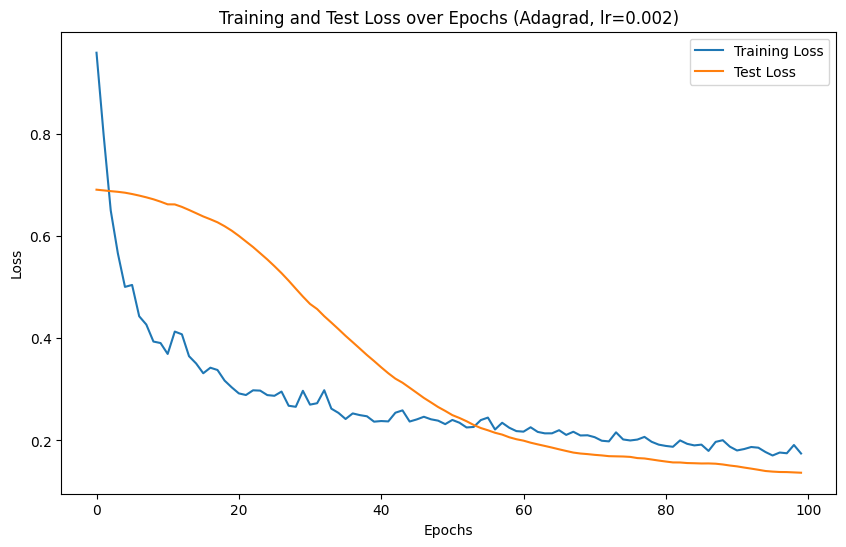

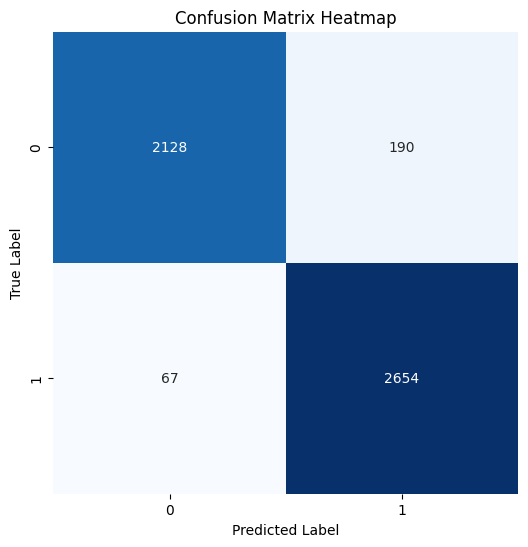

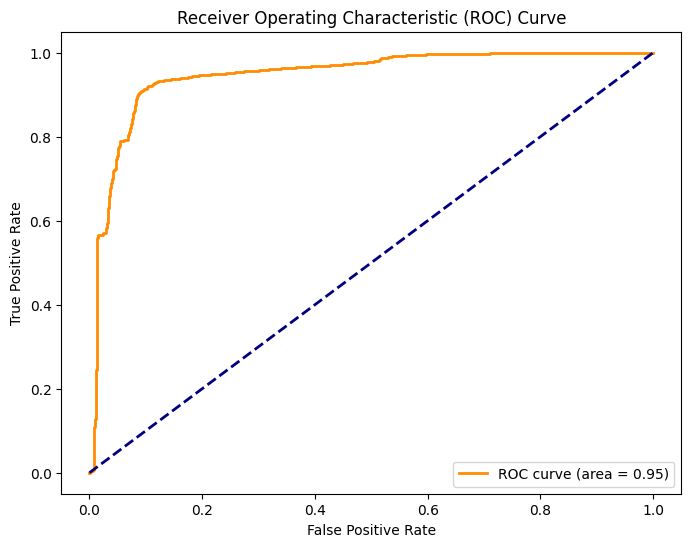


Performance Metrics:
Specificity: 0.9180
FAR: 0.08
Precision: 0.9332
Recall: 0.9754
F1 Score: 0.9538
Accuracy: 0.9490
Training with Adagrad optimizer, learning rate: 0.0025
Epoch [1/100], Train Loss: 1.0043970346450806, Test Loss: 0.688135027885437
Epoch [2/100], Train Loss: 0.8172863125801086, Test Loss: 0.6872865557670593
Epoch [3/100], Train Loss: 0.6621628999710083, Test Loss: 0.6866022944450378
Epoch [4/100], Train Loss: 0.526462972164154, Test Loss: 0.6853585839271545
Epoch [5/100], Train Loss: 0.49984148144721985, Test Loss: 0.6838840842247009
Epoch [6/100], Train Loss: 0.48027345538139343, Test Loss: 0.6822077631950378
Epoch [7/100], Train Loss: 0.4650818705558777, Test Loss: 0.680170476436615
Epoch [8/100], Train Loss: 0.4392159879207611, Test Loss: 0.677952766418457
Epoch [9/100], Train Loss: 0.407192200422287, Test Loss: 0.6751086115837097
Epoch [10/100], Train Loss: 0.3984081447124481, Test Loss: 0.6720286011695862
Epoch [11/100], Train Loss: 0.3934299945831299, Test Loss:

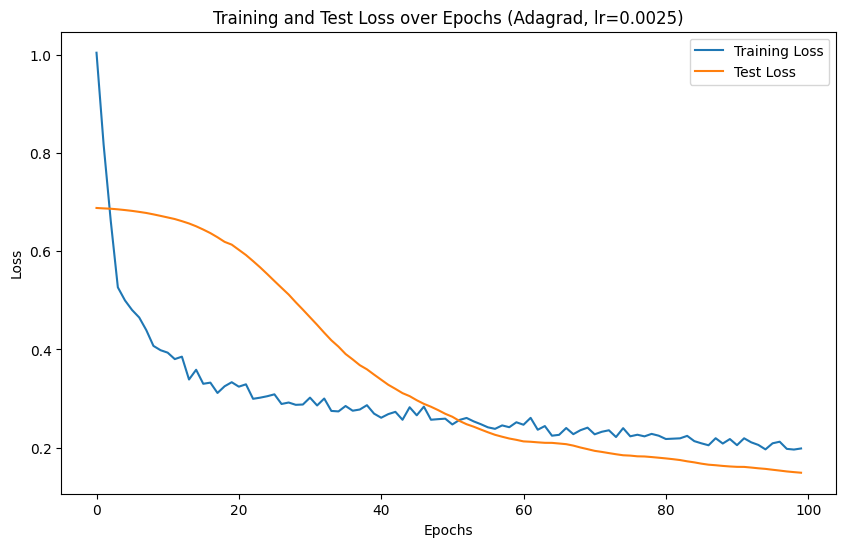

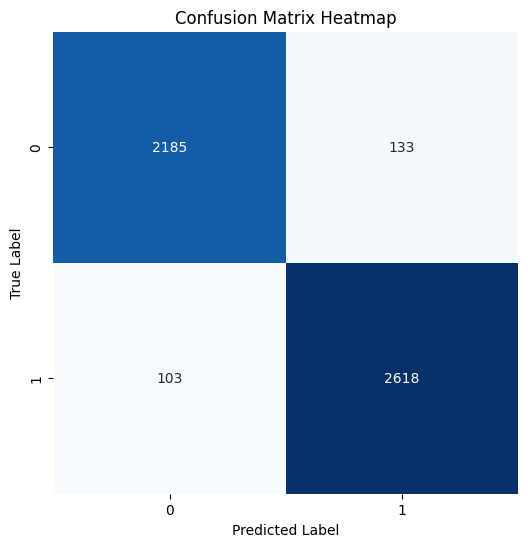

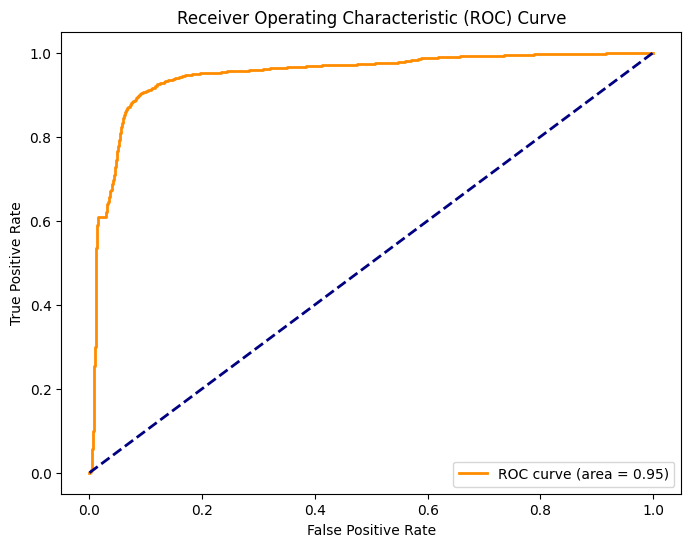


Performance Metrics:
Specificity: 0.9426
FAR: 0.06
Precision: 0.9517
Recall: 0.9621
F1 Score: 0.9569
Accuracy: 0.9532


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.LeakyReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
patience = 10

learning_rates = [0.002, 0.001, 0.002, 0.0025]

for learning_rate in learning_rates:
    print(f"Training with Adagrad optimizer, learning rate: {learning_rate}")
    import time
    s = time.time()
    snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optim.Adamax, patience)
    t = time.time() - s
    print("training time:", t)

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs (Adagrad, lr={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate performance metrics
    conf_mat = confusion_matrix(test_labels, predicted)
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    specificity = TN / (TN + FP)
    far = FP / (FP + TN)
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.4f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("Accuracy: {:.4f}".format(accuracy))

Training with Adagrad optimizer, learning rate: 0.005
Epoch [1/100], Train Loss: 0.943721354007721, Test Loss: 0.6887681484222412
Epoch [2/100], Train Loss: 0.7878325581550598, Test Loss: 0.6886988282203674
Epoch [3/100], Train Loss: 0.6874365210533142, Test Loss: 0.6854325532913208
Epoch [4/100], Train Loss: 0.5128108859062195, Test Loss: 0.6844557523727417
Epoch [5/100], Train Loss: 0.4900226593017578, Test Loss: 0.6840565800666809
Epoch [6/100], Train Loss: 0.4303869903087616, Test Loss: 0.6833747625350952
Epoch [7/100], Train Loss: 0.4148486256599426, Test Loss: 0.6824128031730652
Epoch [8/100], Train Loss: 0.36402368545532227, Test Loss: 0.680086612701416
Epoch [9/100], Train Loss: 0.37450388073921204, Test Loss: 0.6759203672409058
Epoch [10/100], Train Loss: 0.33632200956344604, Test Loss: 0.6715989708900452
Epoch [11/100], Train Loss: 0.32072076201438904, Test Loss: 0.6657211780548096
Epoch [12/100], Train Loss: 0.3321470618247986, Test Loss: 0.6594240069389343
Epoch [13/100], T

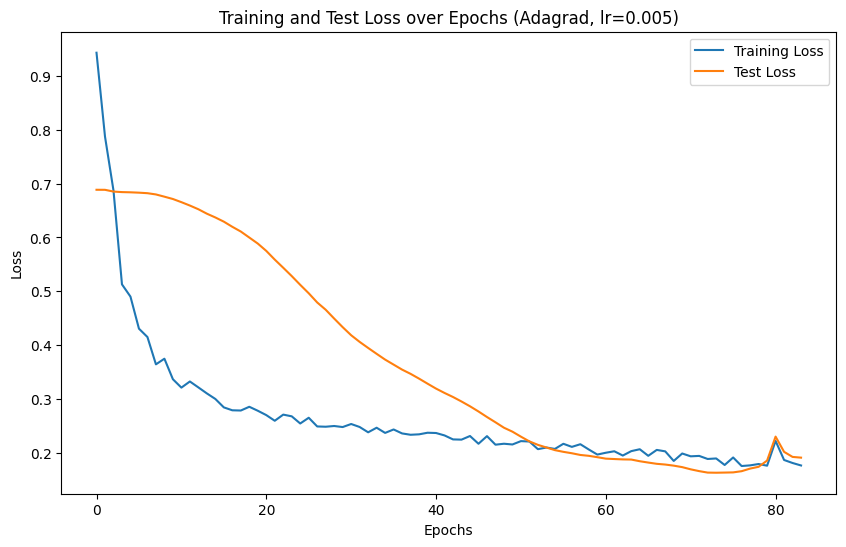

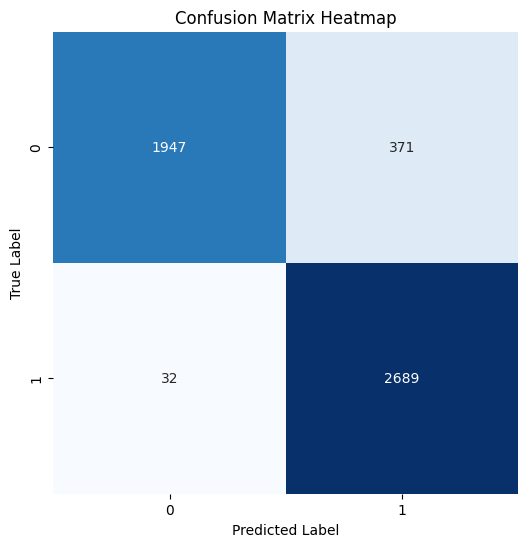

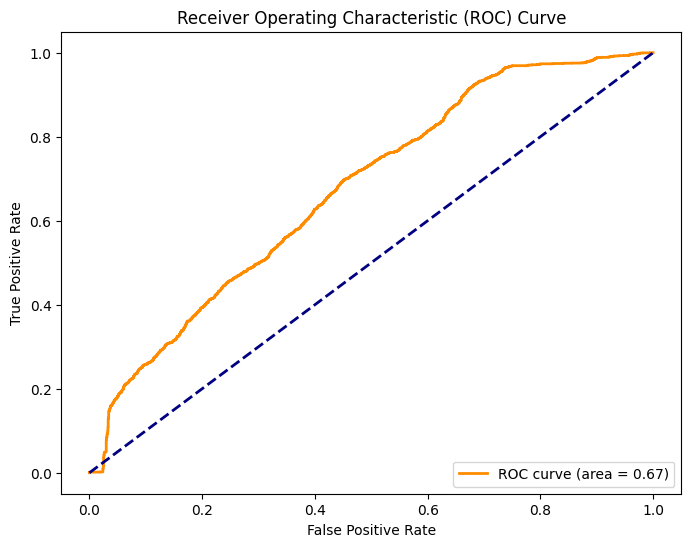


Performance Metrics:
Specificity: 0.8399
FAR: 0.16
Precision: 0.8788
Recall: 0.9882
F1 Score: 0.9303
Accuracy: 0.9200
Training with Adagrad optimizer, learning rate: 0.002
Epoch [1/100], Train Loss: 0.8657507300376892, Test Loss: 0.6904610991477966
Epoch [2/100], Train Loss: 0.7279484272003174, Test Loss: 0.6890579462051392
Epoch [3/100], Train Loss: 0.6542624235153198, Test Loss: 0.6882317662239075
Epoch [4/100], Train Loss: 0.5639214515686035, Test Loss: 0.6876218914985657
Epoch [5/100], Train Loss: 0.5406832098960876, Test Loss: 0.6866623759269714
Epoch [6/100], Train Loss: 0.5128956437110901, Test Loss: 0.6857290267944336
Epoch [7/100], Train Loss: 0.47273334860801697, Test Loss: 0.6844097971916199
Epoch [8/100], Train Loss: 0.4605899751186371, Test Loss: 0.6826277375221252
Epoch [9/100], Train Loss: 0.4339579641819, Test Loss: 0.6806291341781616
Epoch [10/100], Train Loss: 0.40793126821517944, Test Loss: 0.6785909533500671
Epoch [11/100], Train Loss: 0.4025404453277588, Test Loss

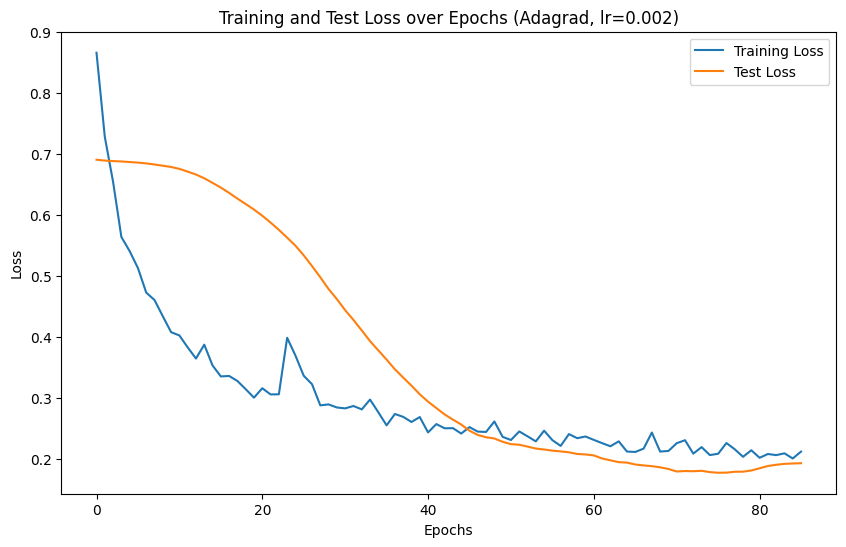

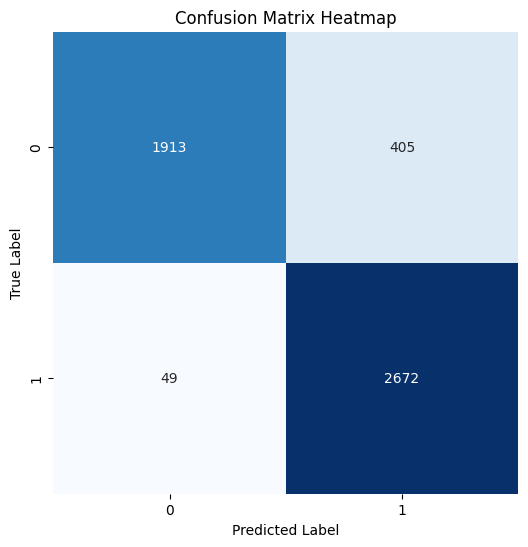

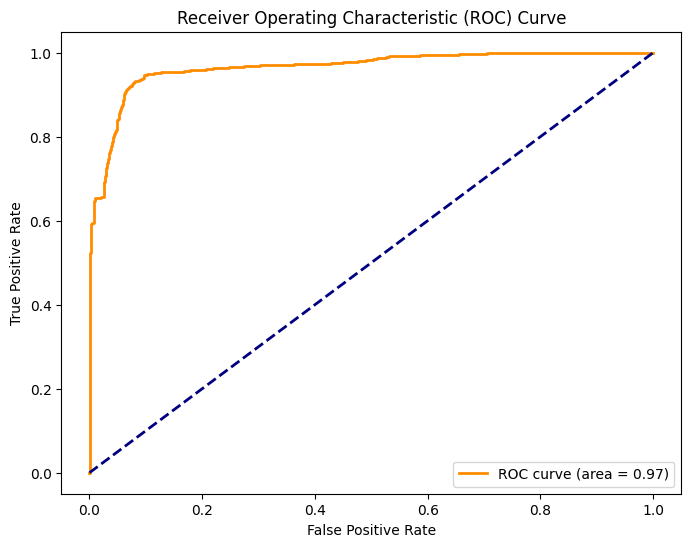


Performance Metrics:
Specificity: 0.8253
FAR: 0.17
Precision: 0.8684
Recall: 0.9820
F1 Score: 0.9217
Accuracy: 0.9099
Training with Adagrad optimizer, learning rate: 0.003
Epoch [1/100], Train Loss: 0.879586398601532, Test Loss: 0.6904096603393555
Epoch [2/100], Train Loss: 0.6652240753173828, Test Loss: 0.6906631588935852
Epoch [3/100], Train Loss: 0.565584659576416, Test Loss: 0.6891312003135681
Epoch [4/100], Train Loss: 0.5194132924079895, Test Loss: 0.6874490976333618
Epoch [5/100], Train Loss: 0.462299644947052, Test Loss: 0.6860049962997437
Epoch [6/100], Train Loss: 0.41619783639907837, Test Loss: 0.6850249171257019
Epoch [7/100], Train Loss: 0.3842135965824127, Test Loss: 0.6839651465415955
Epoch [8/100], Train Loss: 0.38276204466819763, Test Loss: 0.6823962926864624
Epoch [9/100], Train Loss: 0.3479517698287964, Test Loss: 0.6806728839874268
Epoch [10/100], Train Loss: 0.3414131999015808, Test Loss: 0.6782967448234558
Epoch [11/100], Train Loss: 0.3380119502544403, Test Loss

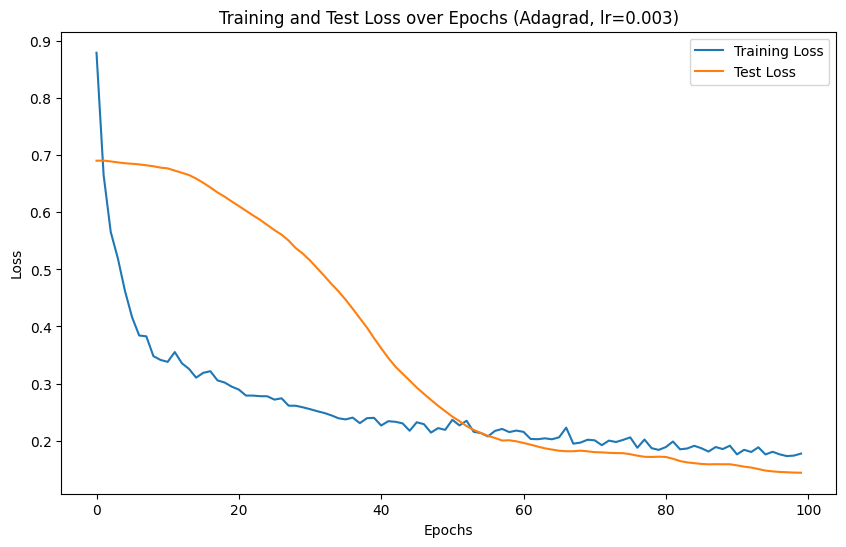

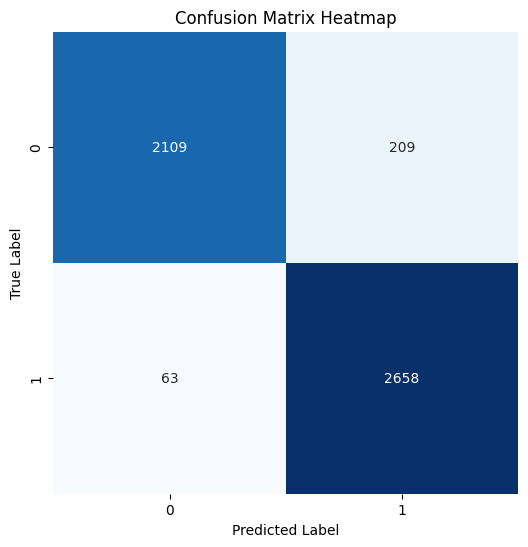

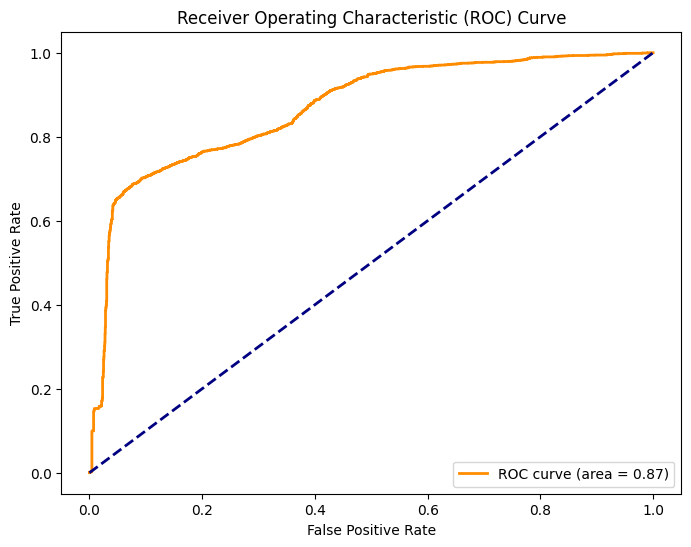


Performance Metrics:
Specificity: 0.9098
FAR: 0.09
Precision: 0.9271
Recall: 0.9768
F1 Score: 0.9513
Accuracy: 0.9460
Training with Adagrad optimizer, learning rate: 0.0025
Epoch [1/100], Train Loss: 0.8901739716529846, Test Loss: 0.7106820344924927
Epoch [2/100], Train Loss: 0.6669251918792725, Test Loss: 0.7008222937583923
Epoch [3/100], Train Loss: 0.5907240509986877, Test Loss: 0.6972849369049072
Epoch [4/100], Train Loss: 0.5550521612167358, Test Loss: 0.6939563155174255
Epoch [5/100], Train Loss: 0.5116122364997864, Test Loss: 0.6905717849731445
Epoch [6/100], Train Loss: 0.49184903502464294, Test Loss: 0.6869209408760071
Epoch [7/100], Train Loss: 0.45875176787376404, Test Loss: 0.6832041144371033
Epoch [8/100], Train Loss: 0.4417272210121155, Test Loss: 0.6790947318077087
Epoch [9/100], Train Loss: 0.4449659287929535, Test Loss: 0.6761376261711121
Epoch [10/100], Train Loss: 0.4352607727050781, Test Loss: 0.6733700633049011
Epoch [11/100], Train Loss: 0.3791869878768921, Test 

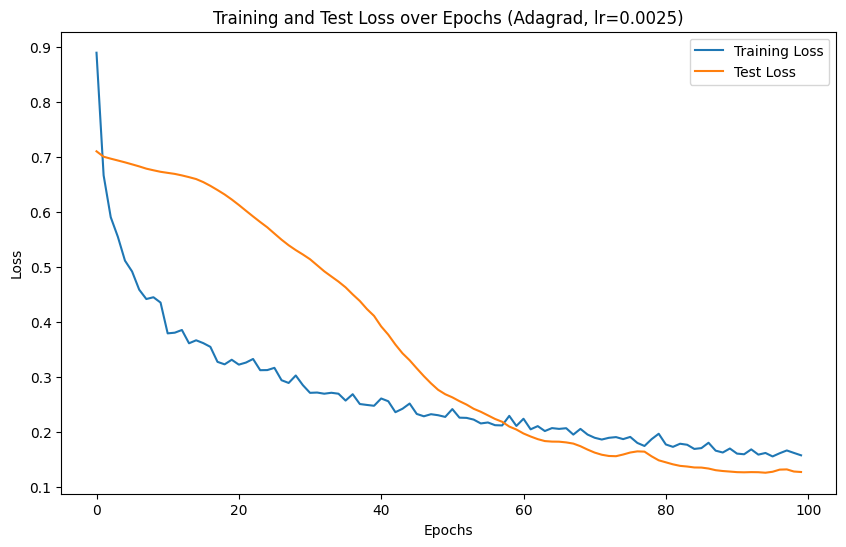

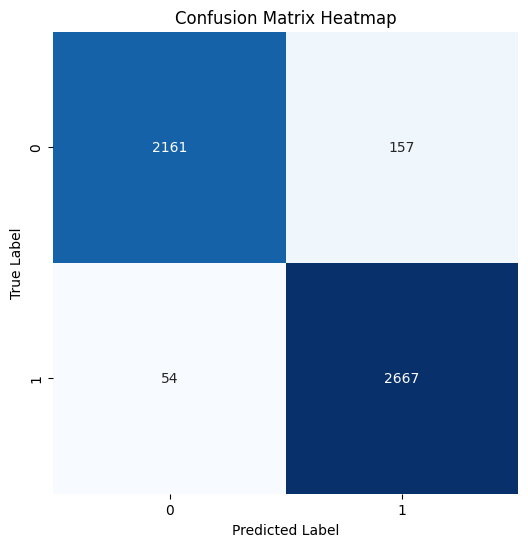

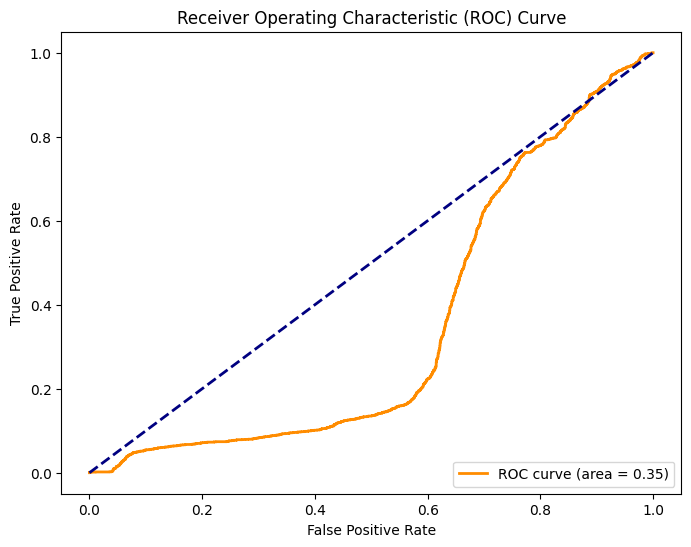


Performance Metrics:
Specificity: 0.9323
FAR: 0.07
Precision: 0.9444
Recall: 0.9802
F1 Score: 0.9619
Accuracy: 0.9581


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.LeakyReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer_class(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
patience = 10

learning_rates = [0.005,0.002,0.003, 0.0025]

for learning_rate in learning_rates:
    print(f"Training with Adagrad optimizer, learning rate: {learning_rate}")
    import time
    s = time.time()
    snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)
    history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optim.Adamax, patience)
    t = time.time() - s
    print("training time:", t)

    # Plot the training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss')
    plt.title(f'Training and Test Loss over Epochs (Adagrad, lr={learning_rate})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # SNN on the test set
    with torch.no_grad():
        test_outputs = snn_model(test_data)
        _, predicted = torch.max(test_outputs, 1)

    # Calculate performance metrics
    conf_mat = confusion_matrix(test_labels, predicted)
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    specificity = TN / (TN + FP)
    far = FP / (FP + TN)
    precision = precision_score(test_labels, predicted)
    recall = recall_score(test_labels, predicted)
    f1 = f1_score(test_labels, predicted)
    accuracy = accuracy_score(test_labels, predicted)

    # Plot Confusion Matrix Heatmap
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, test_outputs[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print performance metrics
    print("\nPerformance Metrics:")
    print("Specificity: {:.4f}".format(specificity))
    print("FAR: {:.2f}".format(far))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1 Score: {:.4f}".format(f1))
    print("Accuracy: {:.4f}".format(accuracy))

Epoch [1/100], Train Loss: 1.0811432600021362, Test Loss: 0.6477833390235901
Epoch [2/100], Train Loss: 0.6560093760490417, Test Loss: 0.6431758403778076
Epoch [3/100], Train Loss: 0.554254949092865, Test Loss: 0.6429166793823242
Epoch [4/100], Train Loss: 0.5153613686561584, Test Loss: 0.6364598274230957
Epoch [5/100], Train Loss: 0.480061411857605, Test Loss: 0.628514289855957
Epoch [6/100], Train Loss: 0.455233633518219, Test Loss: 0.617965579032898
Epoch [7/100], Train Loss: 0.46066609025001526, Test Loss: 0.6094839572906494
Epoch [8/100], Train Loss: 0.41089949011802673, Test Loss: 0.5944554805755615
Epoch [9/100], Train Loss: 0.41068342328071594, Test Loss: 0.5811064839363098
Epoch [10/100], Train Loss: 0.4213194251060486, Test Loss: 0.5684605836868286
Epoch [11/100], Train Loss: 0.4040171205997467, Test Loss: 0.5573812127113342
Epoch [12/100], Train Loss: 0.38718539476394653, Test Loss: 0.5426546931266785
Epoch [13/100], Train Loss: 0.39570727944374084, Test Loss: 0.525461912155

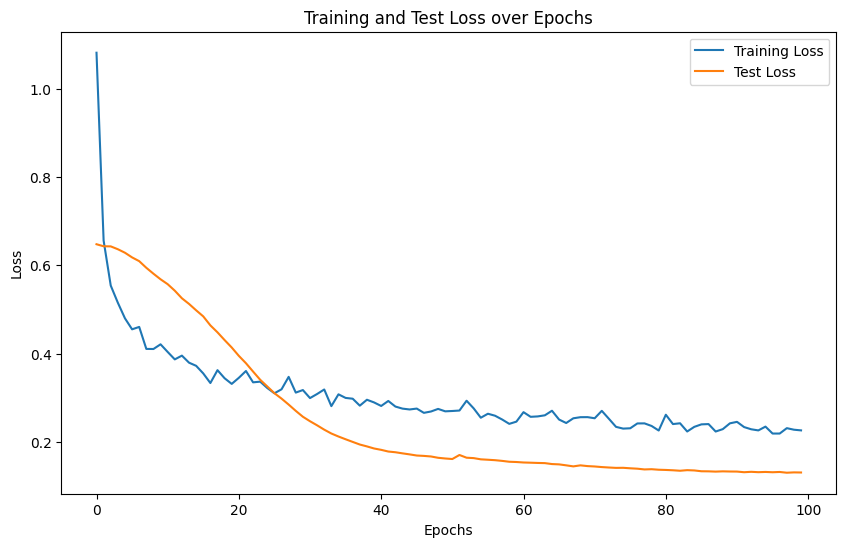

In [ ]:


class SNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate=0.2):
        super(SNN, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size1)
        self.spike = nn.ReLU()
        self.batch_norm1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(p=dropout_rate)

        self.hidden_layer1 = nn.Linear(hidden_size1, hidden_size2)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(p=dropout_rate)

        self.hidden_layer2 = nn.Linear(hidden_size2, hidden_size3)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size3)
        self.dropout3 = nn.Dropout(p=dropout_rate)

        self.attention = nn.MultiheadAttention(hidden_size3, num_heads=4, batch_first=True)

        self.hidden_layer3 = nn.Linear(hidden_size3, hidden_size3)
        self.batch_norm4 = nn.BatchNorm1d(hidden_size3)
        self.dropout4 = nn.Dropout(p=dropout_rate)

        self.synaptic_weights = nn.Parameter(torch.rand(hidden_size3, output_size))
        self.threshold = nn.Parameter(torch.rand(1))

    def forward(self, x):
        x = self.input_layer(x)
        x = self.spike(x - self.threshold)
        x = self.batch_norm1(x)
        x = self.dropout1(x)

        x = self.spike(self.hidden_layer1(x))
        x = self.batch_norm2(x)
        x = self.dropout2(x)

        x = self.spike(self.hidden_layer2(x))
        x = self.batch_norm3(x)
        x = self.dropout3(x)

        x, _ = self.attention(x.unsqueeze(1), x.unsqueeze(1), x.unsqueeze(1))
        x = x.squeeze(1)

        x = self.spike(self.hidden_layer3(x))
        x = self.batch_norm4(x)
        x = self.dropout4(x)

        x = torch.mm(x, self.synaptic_weights)
        return x

# Training loop with test loss and early stopping
def train_snn(model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, optimizer_class, patience=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    history = {'train_loss': [], 'test_loss': []}
    best_test_loss = float('inf')
    no_improvement = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        outputs = model(train_data)
        loss_train = criterion(outputs, labels)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Testing
        model.eval()
        with torch.no_grad():
            outputs_test = model(test_data)
            loss_test = criterion(outputs_test, test_labels)

        # Store training and test loss for visualization
        history['train_loss'].append(loss_train.item())
        history['test_loss'].append(loss_test.item())

        # Early stopping
        if loss_test < best_test_loss:
            best_test_loss = loss_test
            no_improvement = 0
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {loss_train.item()}, Test Loss: {loss_test.item()}')

    return history

# Initialize SNN model and train
input_size = X_train.shape[1]
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 64
output_size = 2
dropout_rate = 0.3
num_epochs = 100
learning_rate = 0.001
patience = 10

snn_model = SNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size, dropout_rate)

import time
s = time.time()
history = train_snn(snn_model, train_data, labels, test_data, test_labels, num_epochs, learning_rate, patience)
t = time.time() - s
print("training time:", t)

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Training and Test Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [ ]:
torch.save(snn_model.state_dict(), "/content/drive/My Drive/Final year project/models/final_model_snn.keras")